# Data Visualization And Description

Two male rhesus primates had single-unit LFP data and kinematics data on their hands.

Hand and Finger Tracking:
* fs = 200 Hz
* 18-camera Vicon optical camera capture system
* 30 optical markers placed on hand and fingers
* spike waveforms sampled at 40 kHz -> Plexon's Offline Spike Sorter
* 128 spike channels and 64 LFP channels
* Each trial is outlined as such:
    1. Variable initial hold of 230-1130 ms on home cylinder
    2. blue LED signaling Cue next to one of the 4 objects
    3. Monkey releases home object (onset of movement = OM)
    4. Apply action to the instructed object (success = switch closure = SC)
    5. Final hold (FH) for 1000 ms
    6. Blue LED turned off and monkey receives reward
    7. Reset to home cylinder object
    8. **Note: Trials aborted if release during initial hold, or holds home more then 1 second after Cue.**
   
   
trial# = MATLAB struct object containing the kinematic variables collected during trial #, where #=1, 2, 3,... Each struct object trial# contains the following fields:

1. trialnum = the number of the trial in the original sequence of experiments
2. eventdata = 1×M array of integers in single precision indicating the sequence of M behavioral event marker codes generated by the TEMPO behavioral control system during the trial. See next section for a description of the codes;
3. eventts = 1×M array of numbers in single precision indicating the time stamp (in sec) of the behavioral event markers generated by the TEMPO behavioral control system during the trial. The generic k-th entry in eventts is the time of the k-th event marker in eventdata;


Questions:
1. Where is 0,0,0 of the cartesian coords of the kinematics data?
    

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import json
import os
from IPython.display import display

import scipy, scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')
from natsort import natsorted, ns

%matplotlib inline

## sklearn imports
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.grid_search

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray):
            dict[strg] = _tolist(elem)
        else:
            dict[strg] = elem
    return dict

def _tolist(ndarray):
    '''
    A recursive function which constructs lists from cellarrays 
    (which are loaded as numpy ndarrays), recursing into the elements
    if they contain matobjects.
    '''
    elem_list = []            
    for sub_elem in ndarray:
        if isinstance(sub_elem, scipy.io.matlab.mio5_params.mat_struct):
            elem_list.append(_todict(sub_elem))
        elif isinstance(sub_elem,np.ndarray):
            elem_list.append(_tolist(sub_elem))
        else:
            elem_list.append(sub_elem)
    return elem_list

In [3]:
dataFile = '../data_X0918.mat'
data = loadmat(dataFile)

In [5]:
neurons = data['neurons']
kinematics = data['kinematics']
lfp = data['lfp']

## 1. Kinematics Analysis

In [17]:
print kinematics.keys()
print kinematics['pull'].keys()
print len(kinematics['pull'].keys())

['vidrate', 'pull', 'mallet', 'marker_name', 'sphere', 'push']
['trial69', 'trial68', 'trial61', 'trial60', 'trial63', 'trial62', 'trial65', 'trial64', 'trial67', 'trial66', 'trial89', 'trial88', 'avg_hand_pos', 'trial83', 'trial82', 'trial81', 'trial80', 'trial87', 'trial86', 'trial85', 'trial84', 'trial76', 'trial77', 'trial74', 'trial75', 'trial72', 'trial73', 'trial70', 'trial71', 'trial78', 'trial79', 'trial98', 'trial99', 'trial90', 'trial91', 'trial92', 'trial93', 'trial94', 'trial95', 'trial96', 'trial97', 'trial112', 'trial113', 'trial110', 'trial111', 'avg_cue_hand_pos', 'trial10', 'trial11', 'trial12', 'trial13', 'trial14', 'trial15', 'trial16', 'trial17', 'trial18', 'trial19', 'trial109', 'trial108', 'trial105', 'trial104', 'trial107', 'trial106', 'trial101', 'trial100', 'trial103', 'trial102', 'trial29', 'trial28', 'trial25', 'trial24', 'trial27', 'trial26', 'trial21', 'trial20', 'trial23', 'trial22', 'trial49', 'trial48', 'trial47', 'trial46', 'trial45', 'trial44', 'trial

In [33]:
pull = kinematics['pull']
mallet = kinematics['mallet']
sphere = kinematics['sphere']
push = kinematics['push']
marker_names = pd.DataFrame(kinematics['marker_name'])

print "The 30 optical markers are: "
display(marker_names.transpose())

print "\nThe video aquisition rate of the optical markers is: ", kinematics['vidrate']

for data in [pull, mallet, sphere, push]:
    num_trials =len(data.keys()) - 3
    avge_hand_pos = np.asarray(data['avg_hand_pos'])
    avge_cue_pos = np.asarray(data['avg_cue_hand_pos'])
    avge_switch_pos = np.asarray(data['avg_switch_hand_pos'])
    
#     dframe = pd.DataFrame({
#             'Average Cue Positions': avge_cue_pos, 
#             'Average Hand Positions': avge_hand_pos, 
#             'Average Switch Positions': avge_switch_pos}, index=['x','y', 'z'])
    
#     display(dframe.head())
    print "\n", num_trials
    print avge_hand_pos.shape
    print avge_cue_pos.shape
    print avge_switch_pos.shape
    
print avge_hand_pos
print avge_cue_pos
print avge_switch_pos

The 30 optical markers are: 


0     1     2     3     4     5    6    7     8     9     10    11    12  \
0  Arm1  Arm2  Arm3  Arm4  MC21  MC22  MC3  MC4  MC51  MC52  MC11  MC12  PP11   

     13    14    15    16    17    18    19    20    21    22    23    24  \
0  PP12  PP21  PP22  PP31  PP32  PP41  PP42  PP51  PP52  IP21  IP22  IP31   

     25    26    27    28    29  
0  IP32  IP41  IP42  IP51  IP52


The video aquisition rate of the optical markers is:  200

113
(3, 30)
(3, 30)
(3, 30)

115
(3, 30)
(3, 30)
(3, 30)

117
(3, 30)
(3, 30)
(3, 30)

117
(3, 30)
(3, 30)
(3, 30)
[[  1605   2156   2671   2156   2355   3265   4006   4438   3460   4632
    1565   1956   2427   2861   3341   3479   4572   4539   4885   4822
    5028   5093   3638   3659   4228   3678   4386   3914   4792   4438]
 [-11812  -9856  -9538 -11604  -6203  -5471  -5983  -6130  -7113  -6428
   -5201  -4403  -3909  -3803  -4856  -4850  -4967  -3583  -5087  -3951
   -5601  -4902  -4832  -4174  -2992  -3036  -3401  -3464  -4244  -4274]
 [ 38156  39298  38107  37215  41017  41873  40979  40202  39518  39509
   40601  41274  41504  41319  42293  42474  41324  41529  40529  40686
   39639  40021  42924  42945  41303  40741  40457  40092  40011  39695]]
[[ -1967  -1609  -1897  -2035  -1754  -1693  -1680  -1971  -1691  -2124
   -3533  -3664  -4093  -4618  -2012  -2375  -2670  -4326  -3193  -4762
   -3447  -4479  -2904  -3605

## 2. Neurons Data

In [50]:
print neurons.keys()
print len(neurons.keys())

['sig092b', 'sig092a', 'sig043a', 'sig043b', 'sig104b', 'sig104a', 'sig113b', 'sig112a', 'sig113a', 'sig089b', 'sig089a', 'sig012b', 'sig012a', 'sig118c', 'sig081c', 'sig081b', 'sig081a', 'sig038d', 'sig095a', 'sig040a', 'sig040b', 'sig008a', 'sig008b', 'sig008c', 'sig008d', 'sig071a', 'sig071b', 'sig071c', 'sig102a', 'sig001c', 'sig039a', 'sig039b', 'sig039c', 'sig015b', 'sig015a', 'sig090a', 'sig106a', 'sig058a', 'sig035a', 'sig035b', 'sig098a', 'sig098b', 'sig111a', 'sig111c', 'sig001b', 'sig010a', 'sig010b', 'sig001a', 'sig121b', 'sig094c', 'sig060a', 'sig034d', 'sig034c', 'sig034b', 'sig034a', 'sig105c', 'sig022a', 'sig022b', 'sig042b', 'sig042a', 'sig033b', 'sig033c', 'sig052a', 'sig033a', 'sig033d', 'sig120a', 'sig120c', 'sig120b', 'sig111b', 'sig083a', 'sig003a', 'sig003c', 'sig003b', 'sig105b', 'sig096c', 'sig096b', 'sig096a', 'sig096d', 'sig116a', 'sig027a', 'sig123c', 'sig037b', 'sig037c', 'sig056a', 'sig037a', 'sig075a', 'sig020a', 'sig099b', 'sig099a', 'sig004d', 'sig051a'

In [49]:
sampleNeuron = neurons['sig092b']
pull = sampleNeuron['pull']
mallet = sampleNeuron['mallet']
sphere = sampleNeuron['sphere']
push = sampleNeuron['push']

for data in [pull, mallet, sphere, push]:
    print data.keys()
    sampleTrial = data[data.keys()[0]]
    print sampleTrial.keys()
    print sampleTrial['eventts']
    print sampleTrial['trialnum']
    print sampleTrial['eventdata']
    print sampleTrial['alldata']
    break
    
    
#     num_trials =len(data.keys()) - 3
#     avge_hand_pos = np.asarray(data['avg_hand_pos'])
#     avge_cue_pos = np.asarray(data['avg_cue_hand_pos'])
#     avge_switch_pos = np.asarray(data['avg_switch_hand_pos'])
    
#     print "\n", num_trials
#     print avge_hand_pos.shape
#     print avge_cue_pos.shape
#     print avge_switch_pos.shape

['trial69', 'trial68', 'trial61', 'trial60', 'trial63', 'trial62', 'trial65', 'trial64', 'trial67', 'trial66', 'trial89', 'trial88', 'trial83', 'trial82', 'trial81', 'trial80', 'trial87', 'trial86', 'trial85', 'trial84', 'trial76', 'trial77', 'trial74', 'trial75', 'trial72', 'trial73', 'trial70', 'trial71', 'trial78', 'trial79', 'trial98', 'trial99', 'trial90', 'trial91', 'trial92', 'trial93', 'trial94', 'trial95', 'trial96', 'trial97', 'trial112', 'trial113', 'trial110', 'trial111', 'trial10', 'trial11', 'trial12', 'trial13', 'trial14', 'trial15', 'trial16', 'trial17', 'trial18', 'trial19', 'trial109', 'trial108', 'trial105', 'trial104', 'trial107', 'trial106', 'trial101', 'trial100', 'trial103', 'trial102', 'trial29', 'trial28', 'trial25', 'trial24', 'trial27', 'trial26', 'trial21', 'trial20', 'trial23', 'trial22', 'trial49', 'trial48', 'trial47', 'trial46', 'trial45', 'trial44', 'trial43', 'trial42', 'trial41', 'trial40', 'trial38', 'trial39', 'trial32', 'trial33', 'trial30', 'trial

## 3. LFP Data (if present)


In [52]:
print lfp.keys()

print "There are ", len(lfp.keys()), ' lfp channels'

['AD21', 'AD20', 'AD23', 'AD22', 'AD25', 'AD24', 'AD27', 'AD26', 'AD29', 'AD28', 'AD60', 'AD47', 'AD46', 'AD09', 'AD08', 'AD43', 'AD42', 'AD41', 'AD40', 'AD03', 'AD02', 'AD01', 'AD07', 'AD06', 'AD05', 'AD04', 'AD58', 'AD63', 'AD59', 'AD49', 'AD48', 'AD36', 'AD37', 'AD34', 'AD35', 'AD32', 'AD33', 'AD30', 'AD31', 'AD62', 'AD38', 'AD39', 'AD18', 'AD19', 'AD56', 'AD57', 'AD50', 'AD51', 'AD52', 'AD53', 'AD10', 'AD11', 'AD12', 'AD13', 'AD14', 'AD15', 'AD16', 'AD17', 'AD54', 'AD64', 'AD55', 'AD45', 'AD61', 'AD44']
There are  64  lfp channels


In [57]:
sampleLFP = lfp['AD21']
print sampleLFP.keys()

pull = sampleLFP['pull']
mallet = sampleLFP['mallet']
sphere = sampleLFP['sphere']
push = sampleLFP['push']

for data in [pull, mallet, sphere, push]:
    print data.keys()
    print len(data.keys())
    
    sampleTrial = data['trial69']
    
    print "\nThe trial number in overall experiment seq: ", sampleTrial['trialnum']
    print "The event marker data: ", sampleTrial['eventdata']
    print "The time stamp of each event marker data (seconds): ", sampleTrial['eventts']
    break

['push', 'sphere', 'pull', 'mallet']
['trial69', 'trial68', 'trial61', 'trial60', 'trial63', 'trial62', 'trial65', 'trial64', 'trial67', 'trial66', 'trial89', 'trial88', 'trial83', 'trial82', 'trial81', 'trial80', 'trial87', 'trial86', 'trial85', 'trial84', 'trial76', 'trial77', 'trial74', 'trial75', 'trial72', 'trial73', 'trial70', 'trial71', 'trial78', 'trial79', 'trial98', 'trial99', 'trial90', 'trial91', 'trial92', 'trial93', 'trial94', 'trial95', 'trial96', 'trial97', 'trial112', 'trial113', 'trial110', 'trial111', 'trial10', 'trial11', 'trial12', 'trial13', 'trial14', 'trial15', 'trial16', 'trial17', 'trial18', 'trial19', 'trial109', 'trial108', 'trial105', 'trial104', 'trial107', 'trial106', 'trial101', 'trial100', 'trial103', 'trial102', 'trial29', 'trial28', 'trial25', 'trial24', 'trial27', 'trial26', 'trial21', 'trial20', 'trial23', 'trial22', 'trial49', 'trial48', 'trial47', 'trial46', 'trial45', 'trial44', 'trial43', 'trial42', 'trial41', 'trial40', 'trial38', 'trial39', 't

# 4. Looking At Separate Neuron Data

Each saved mat files is for a single neuron during an experimental condition. Inside the mat file are spike trains during the duration of each trial (in seconds). 

Also contains the behavioral markers (in seconds) and avgrate (spikes/sec).

In [8]:
malletDir = '../Monkey X/mallet/'
pullDir = '../Monkey X/pull/'
pushDir = '../Monkey X/push/'
sphereDir = '../Monkey X/sphere/'

experiments = [malletDir, pullDir, pushDir, sphereDir]

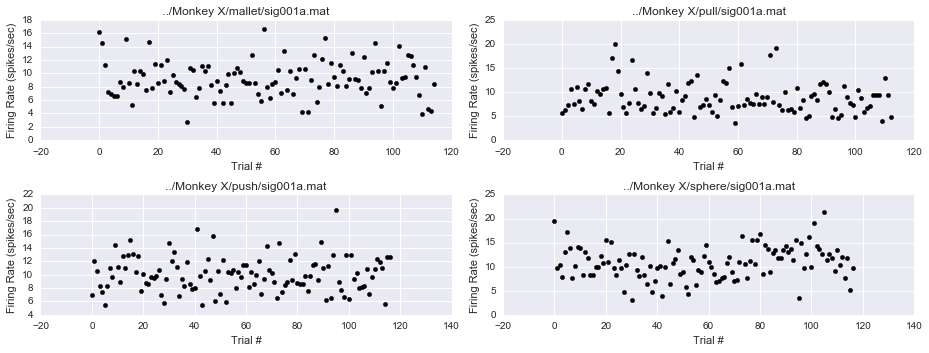

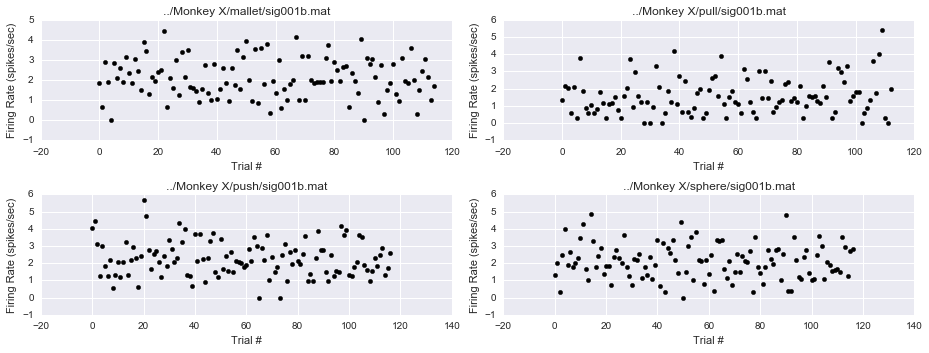

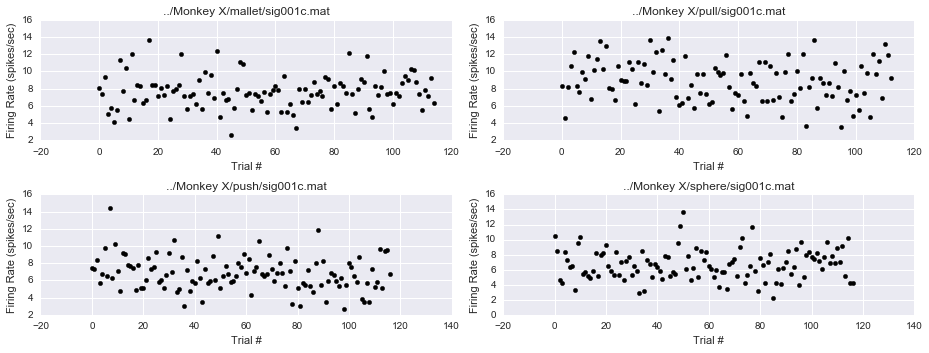

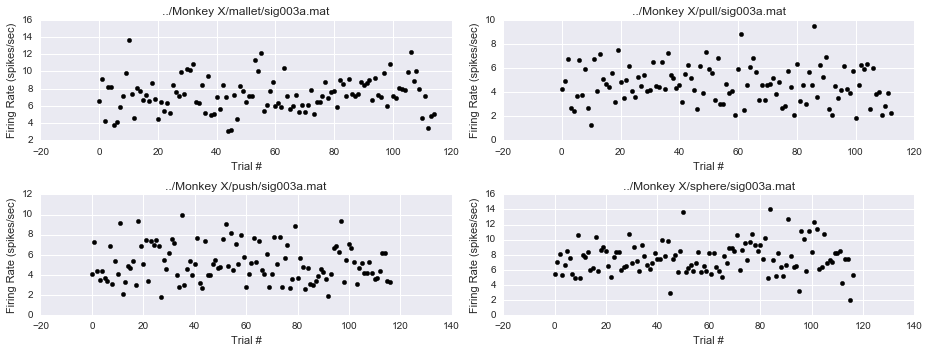

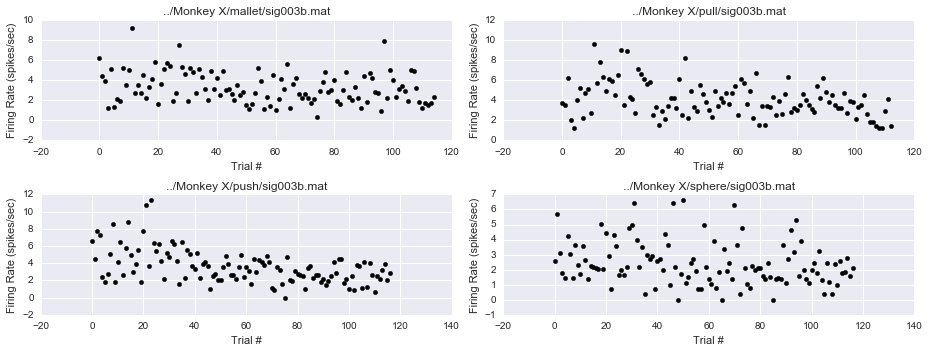

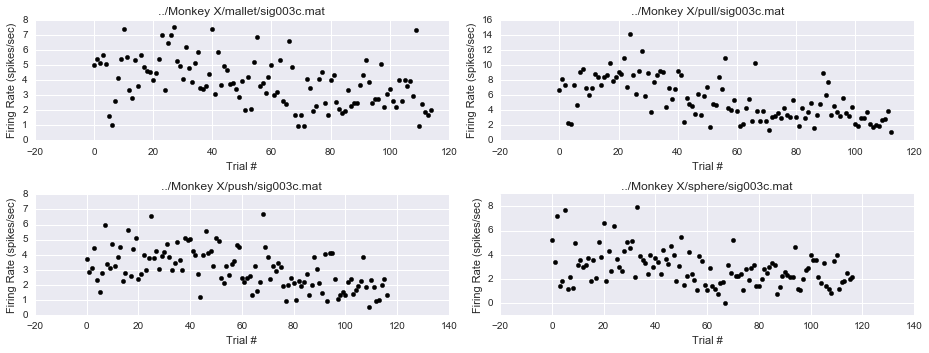

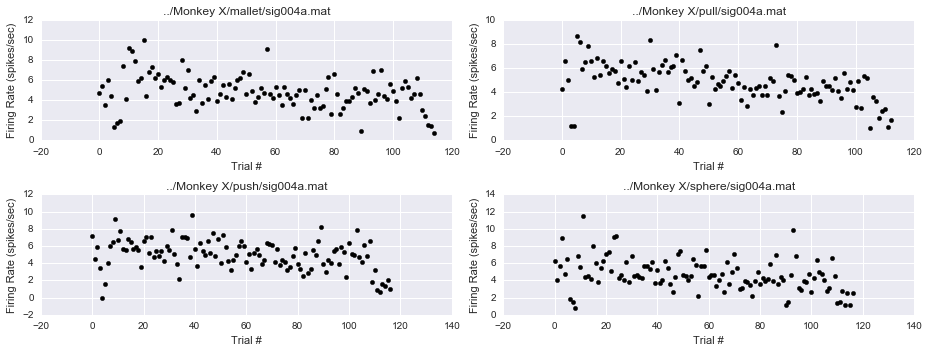

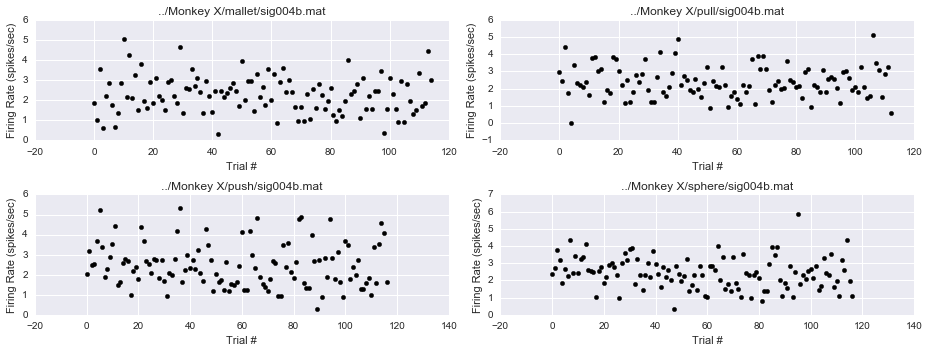

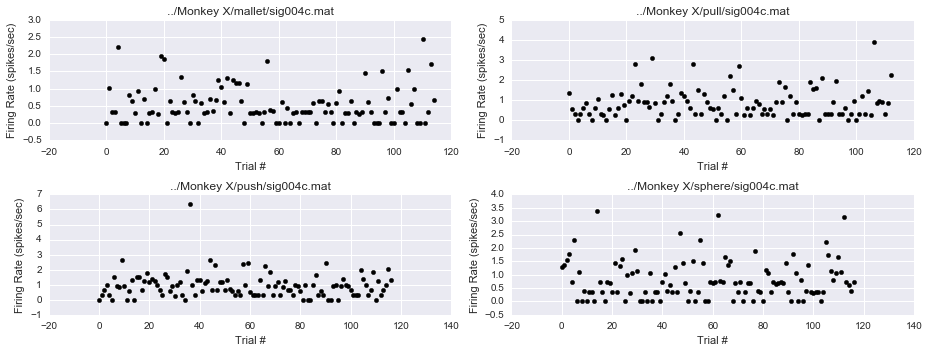

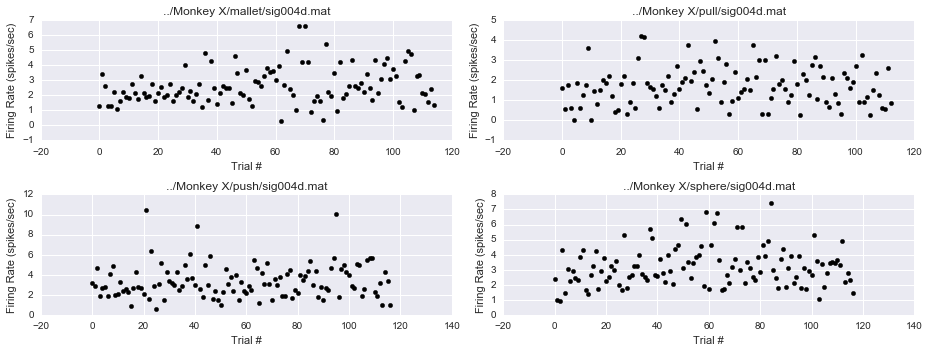

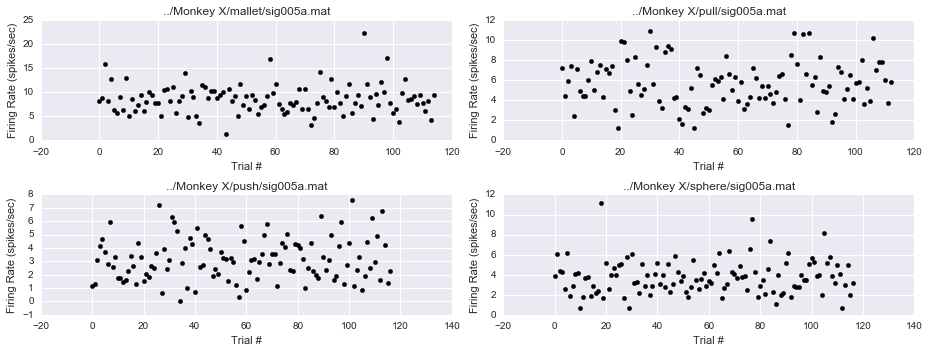

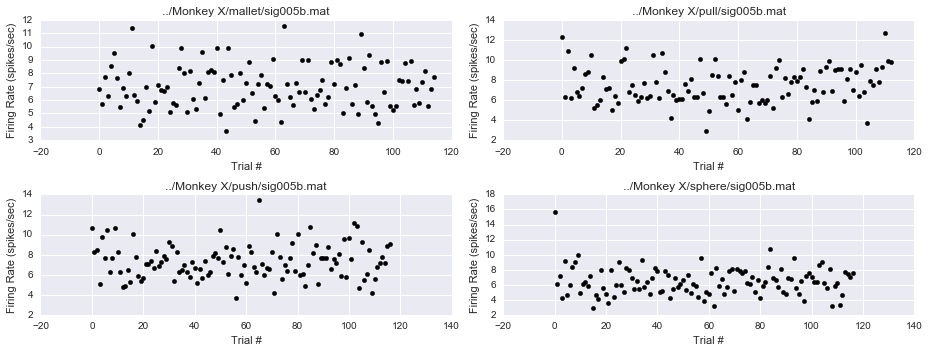

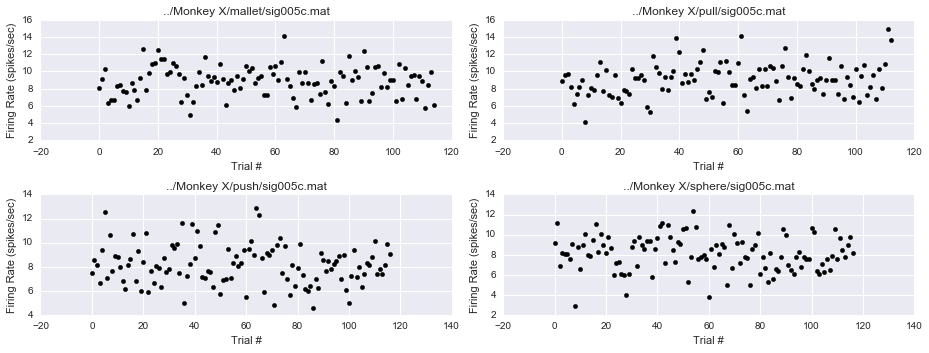

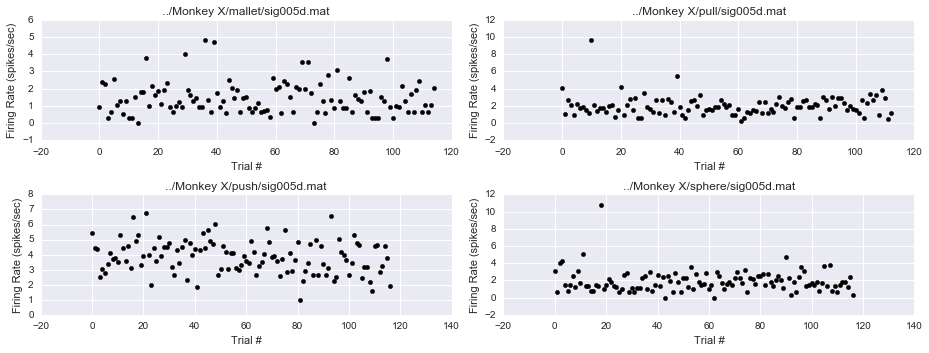

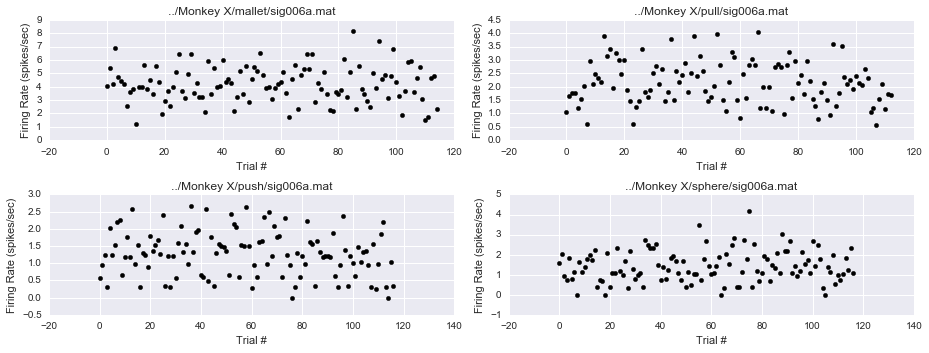

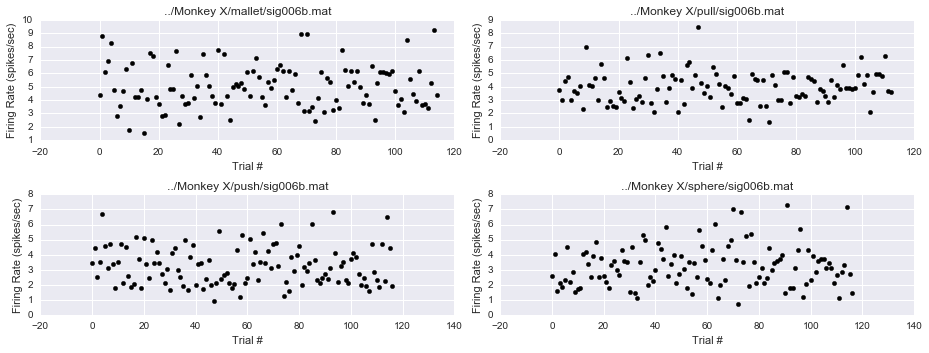

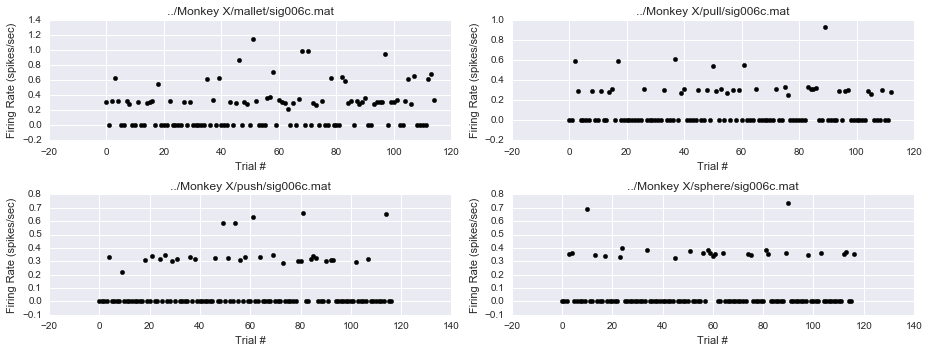

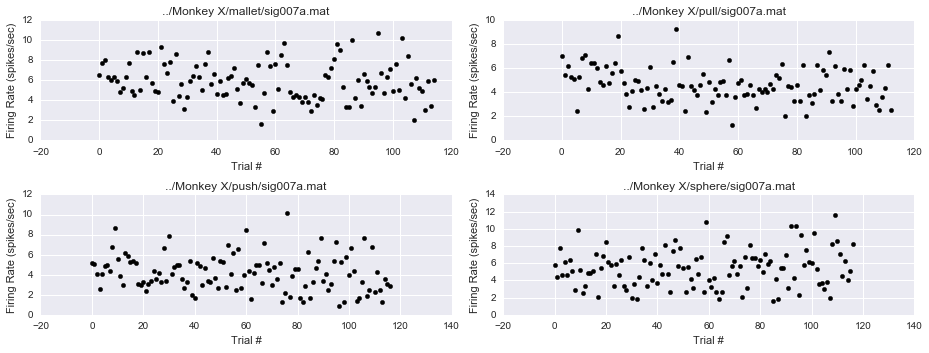

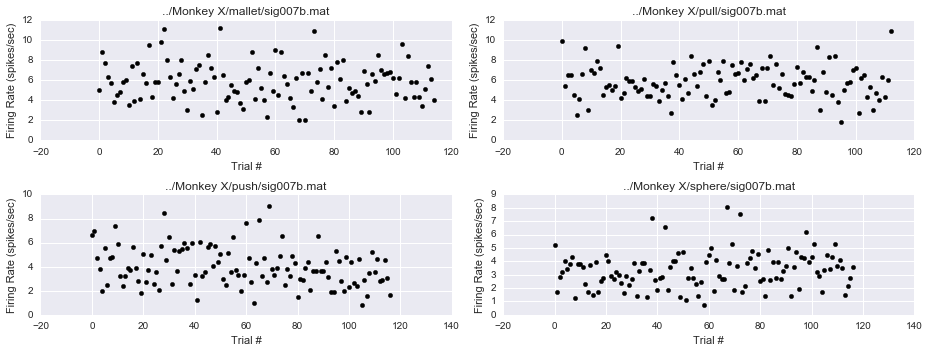

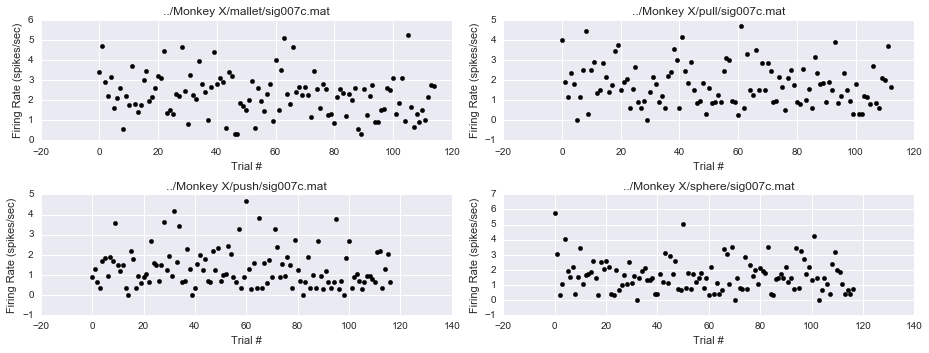

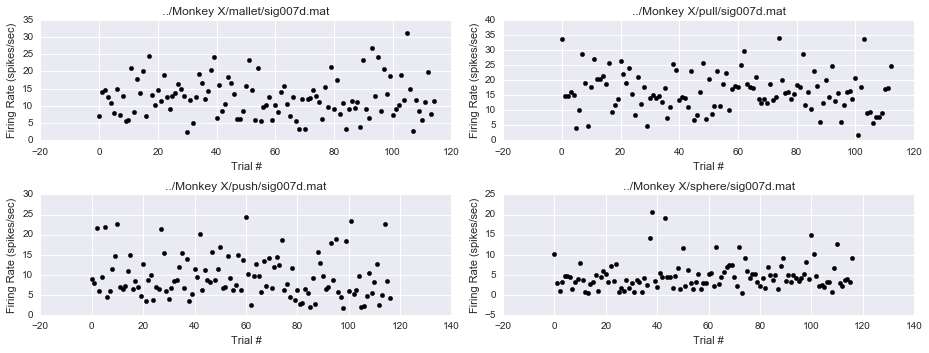

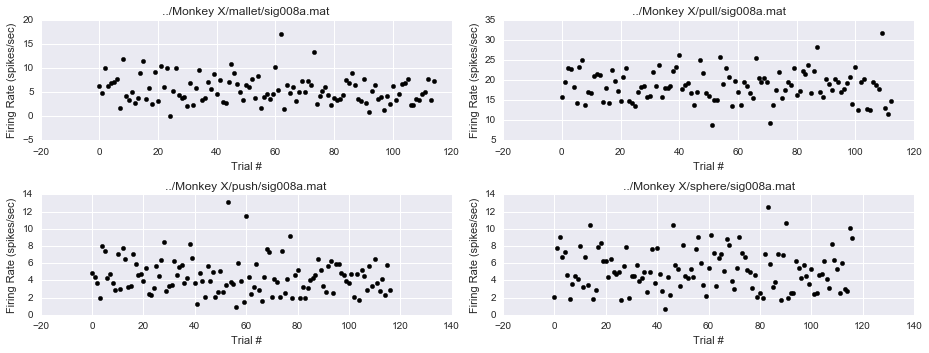

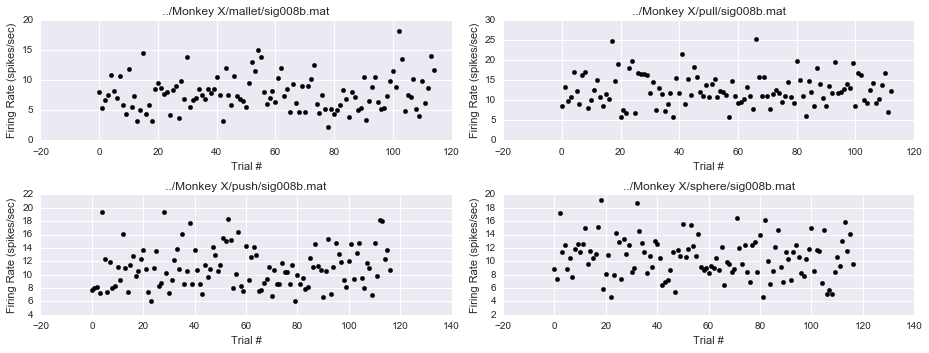

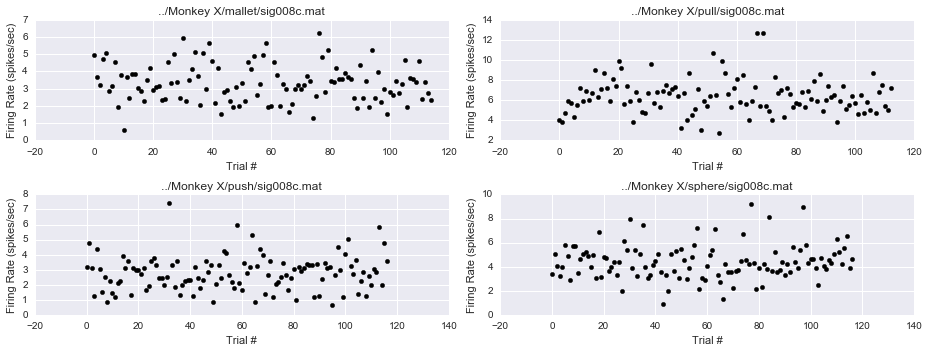

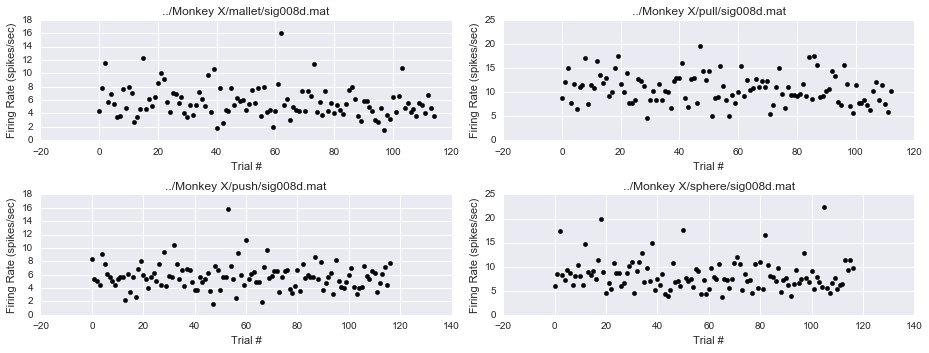

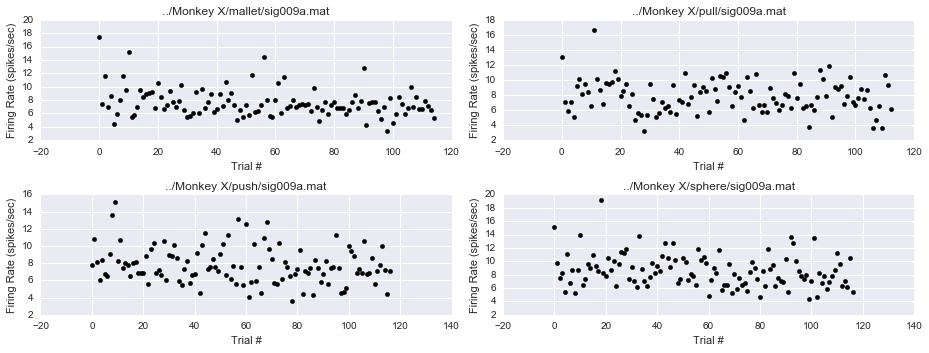

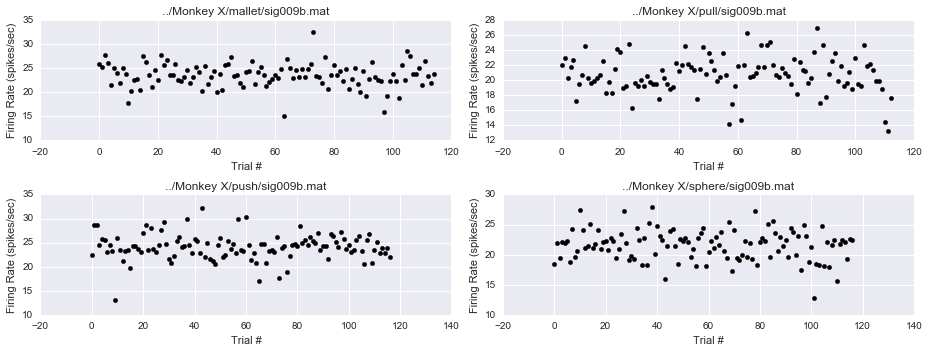

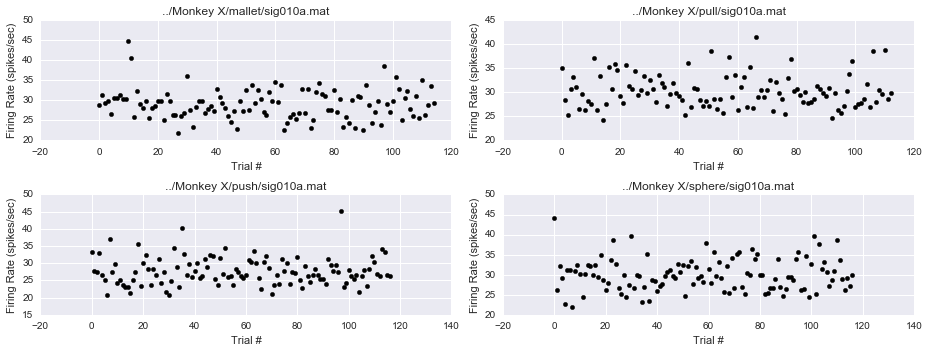

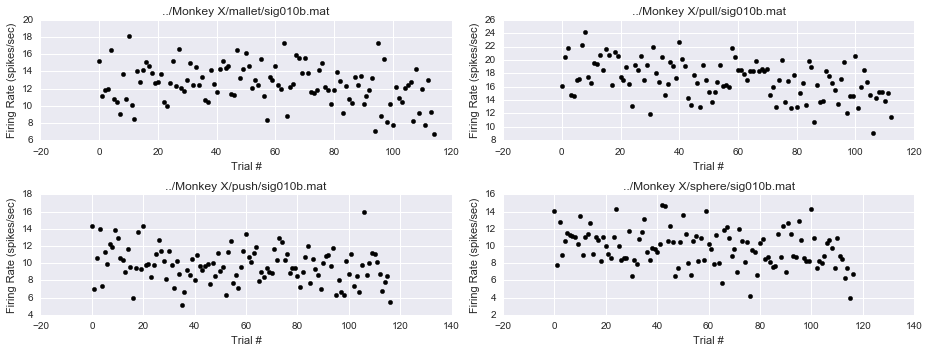

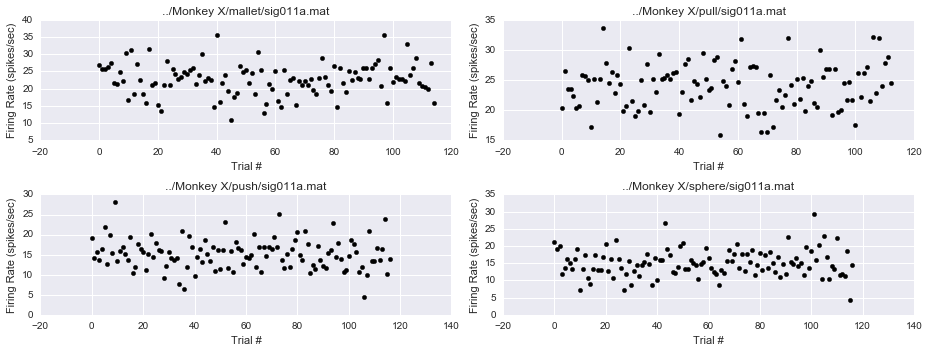

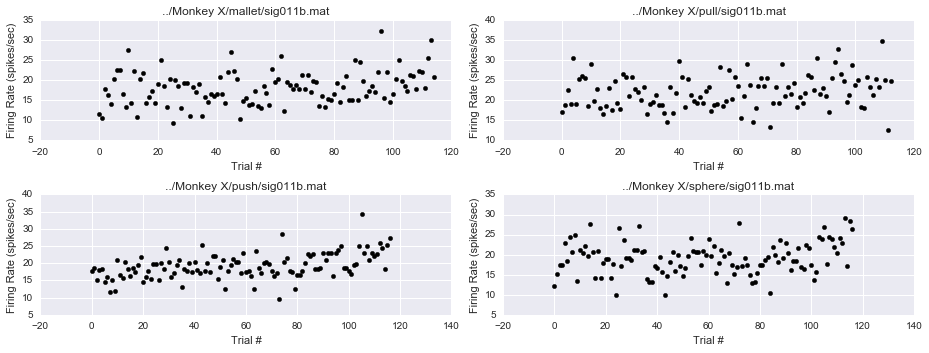

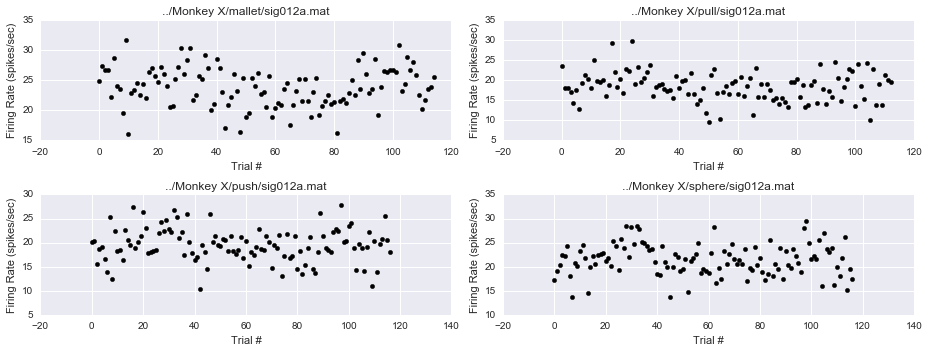

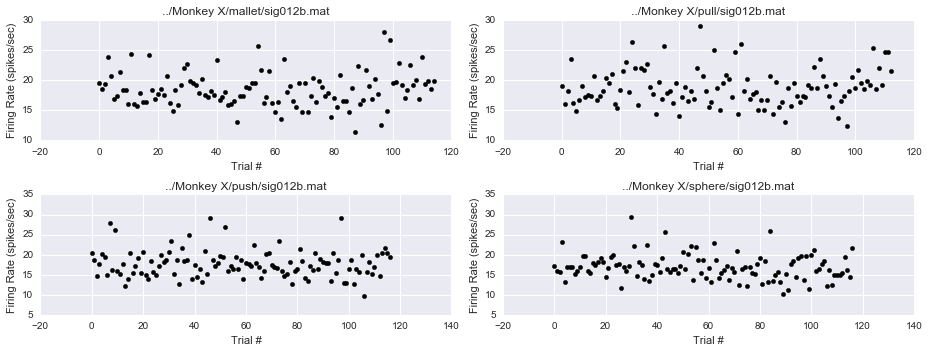

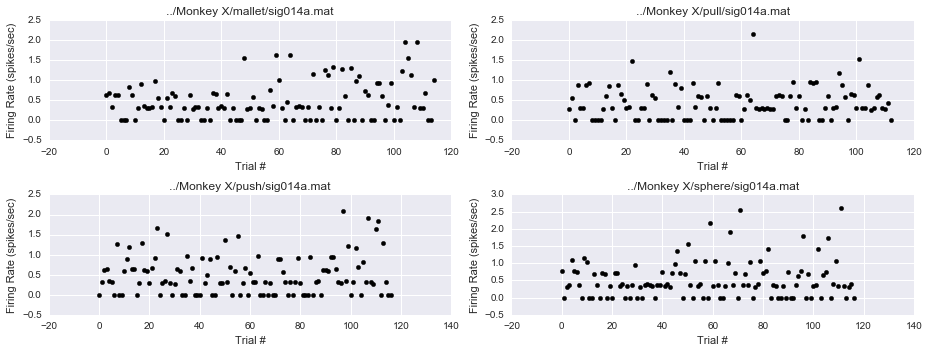

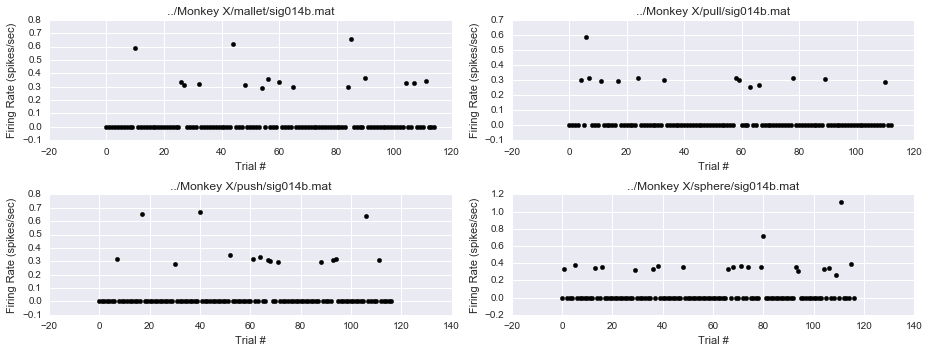

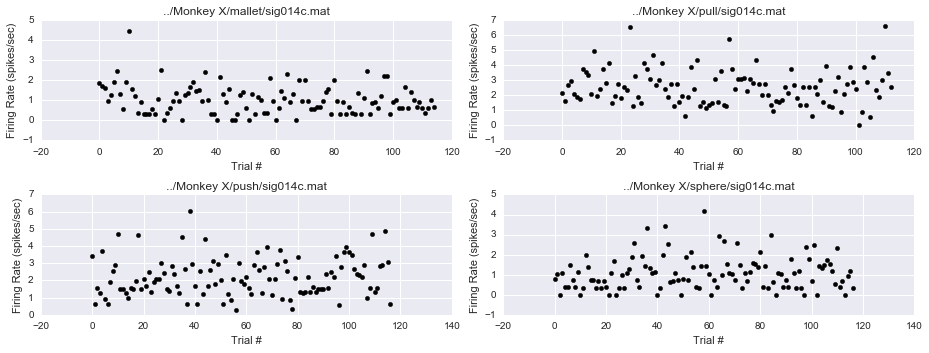

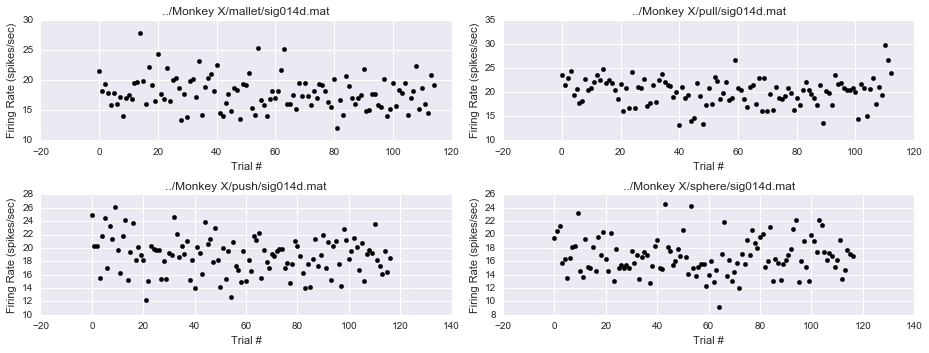

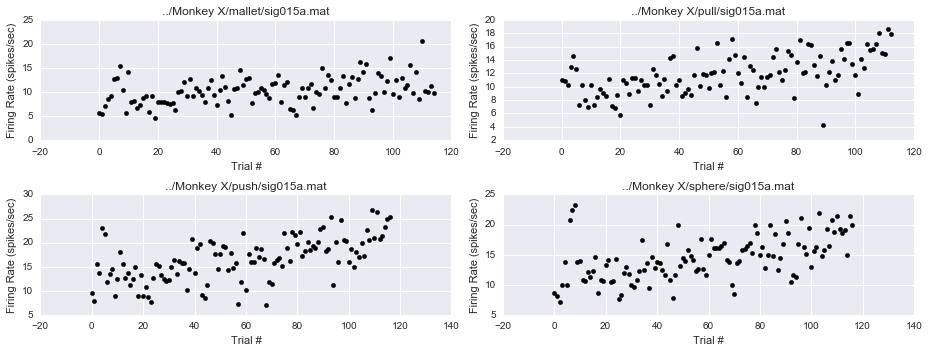

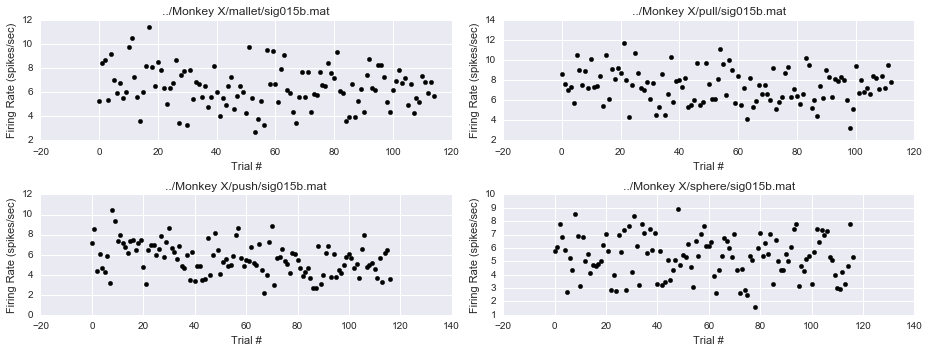

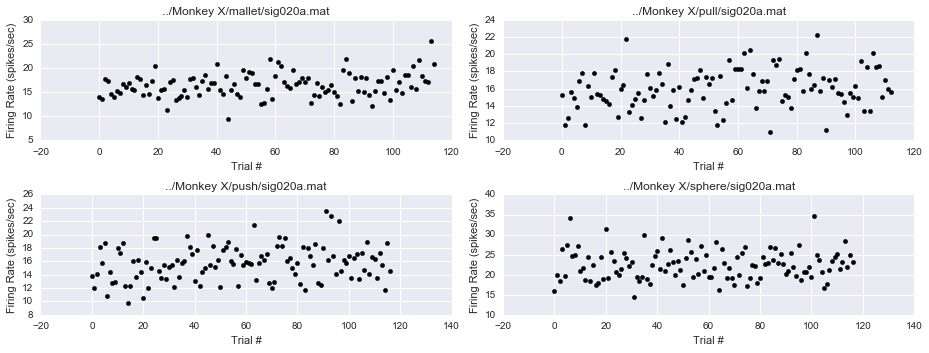

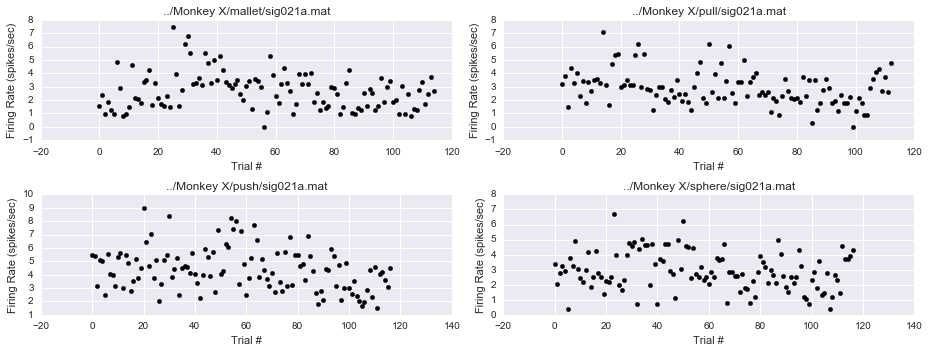

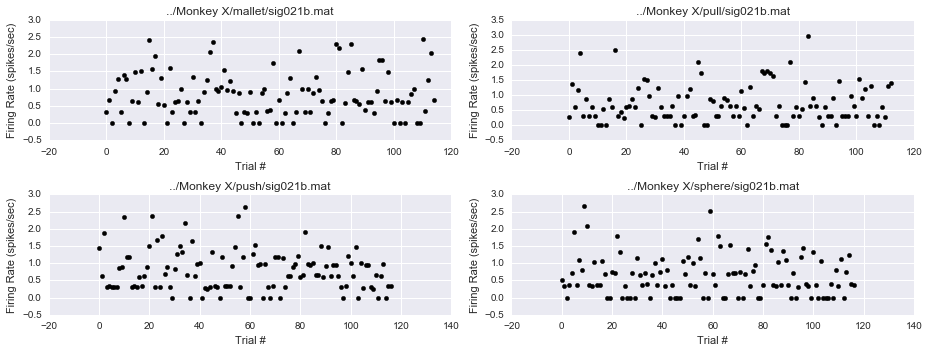

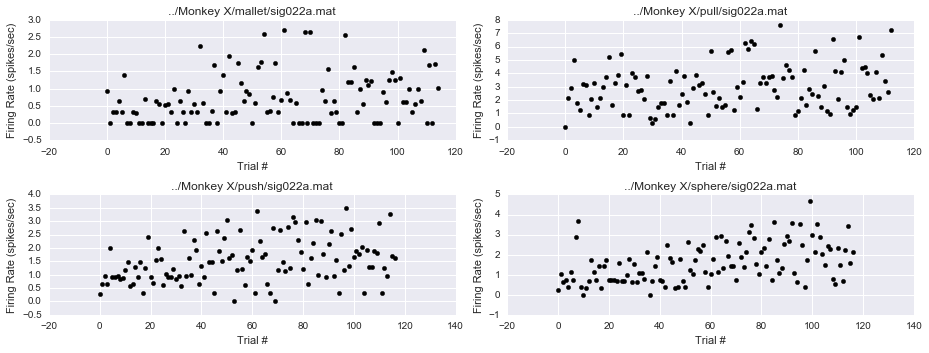

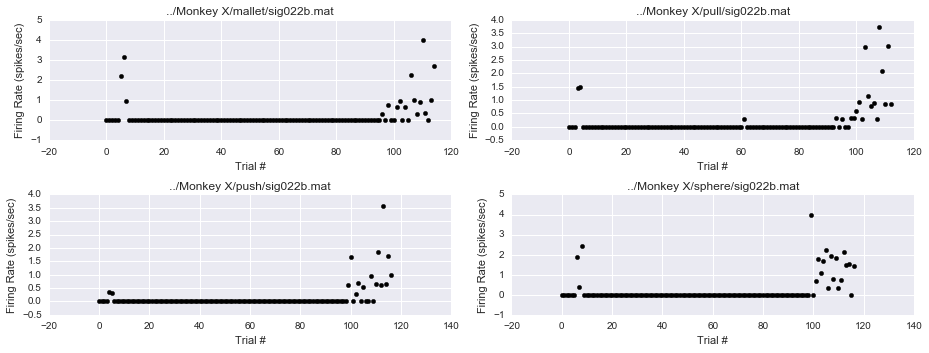

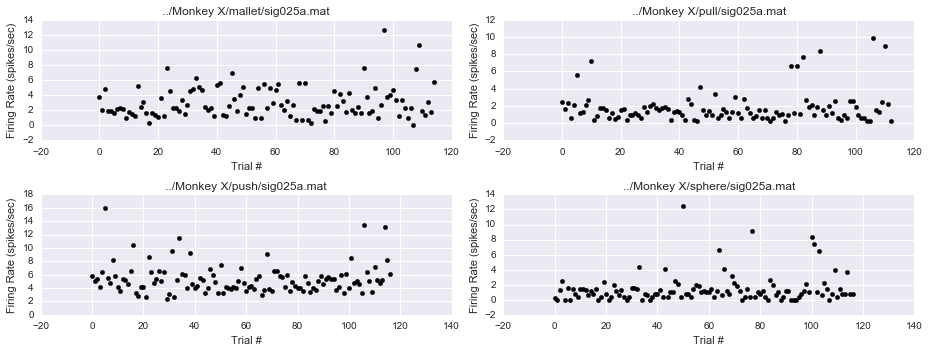

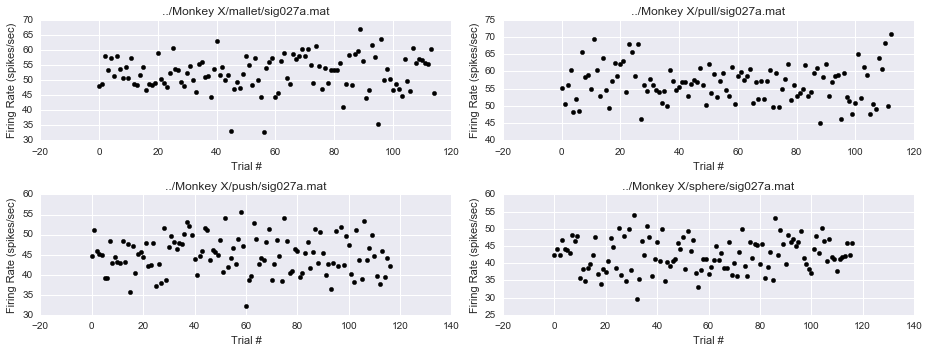

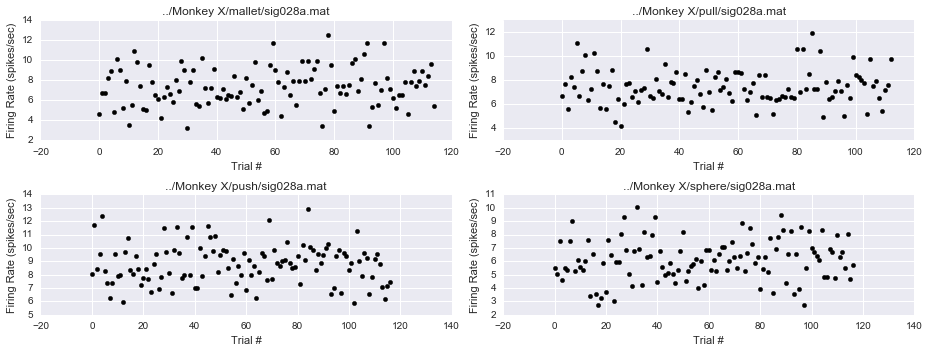

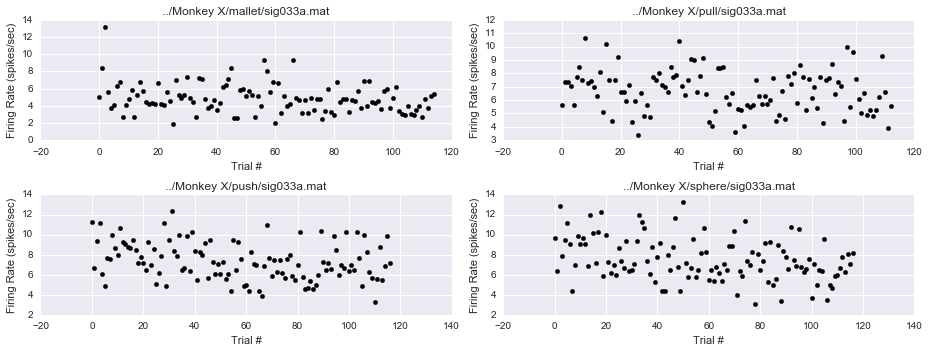

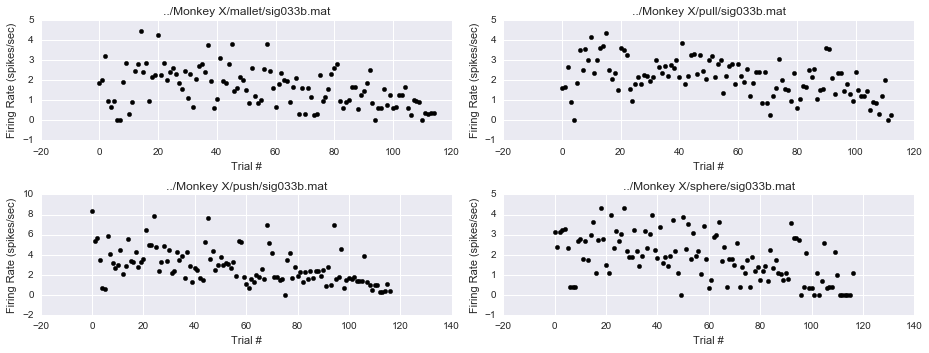

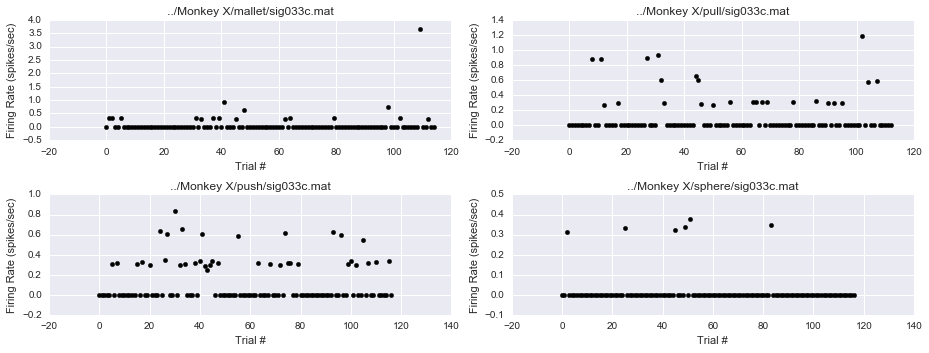

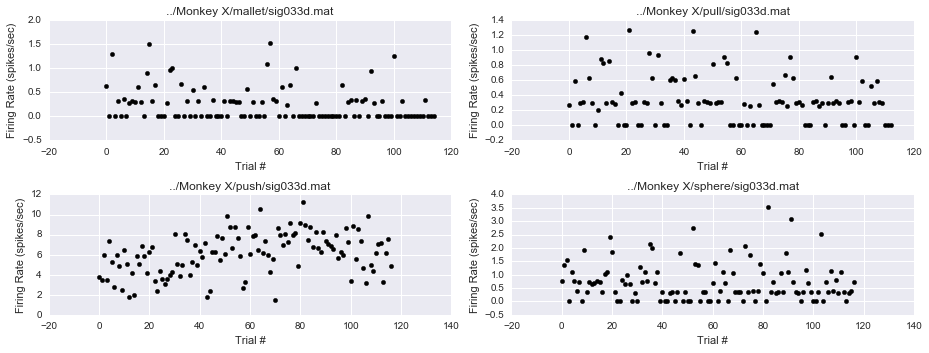

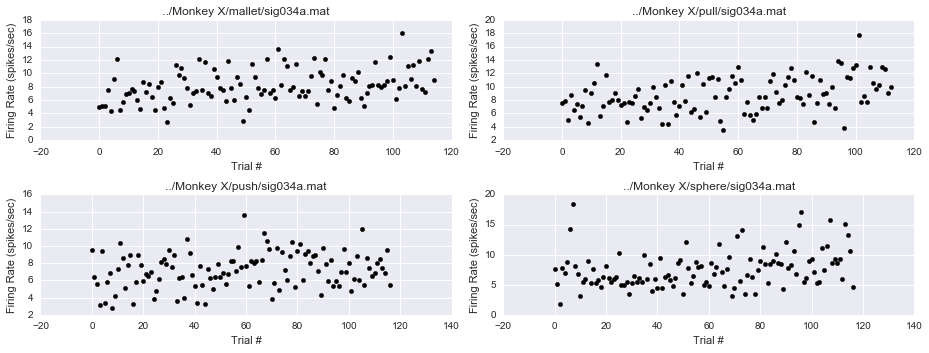

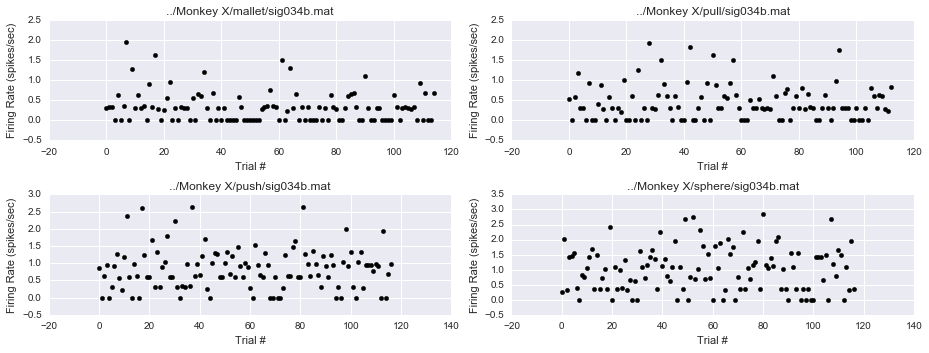

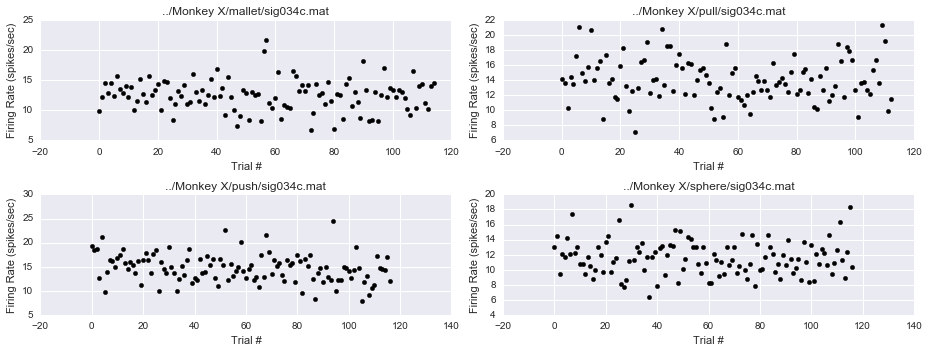

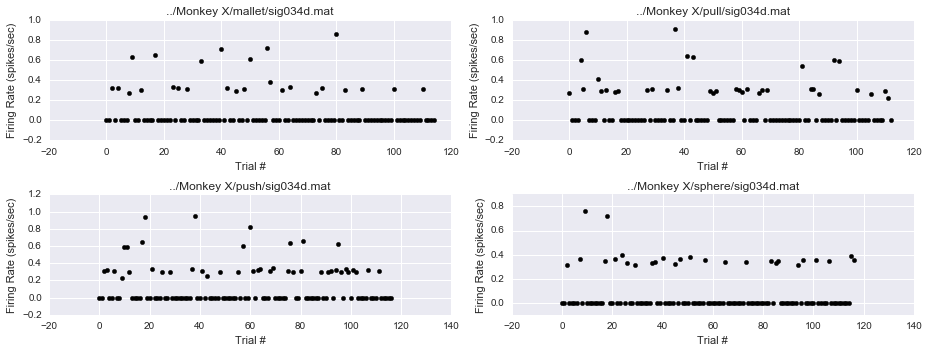

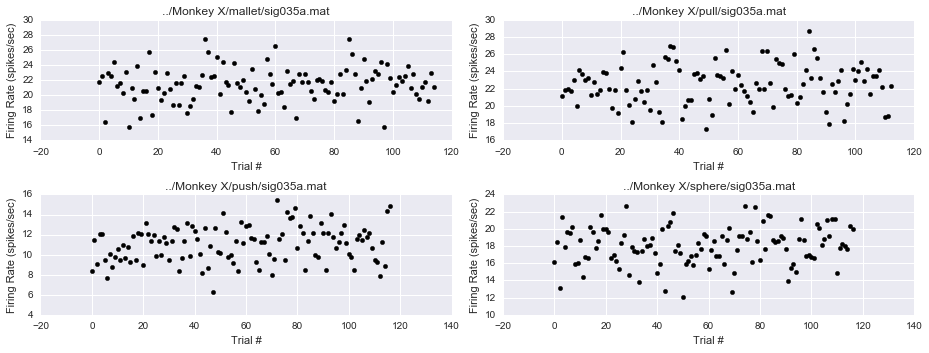

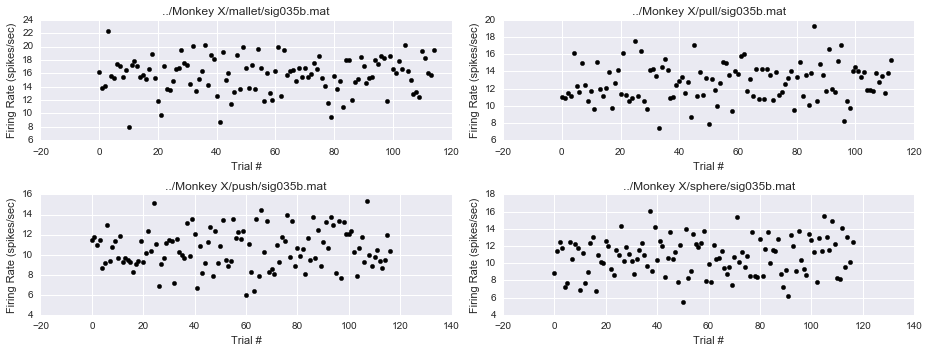

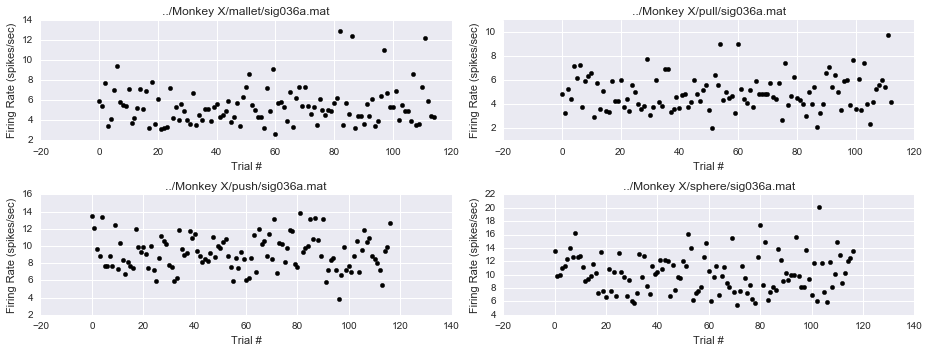

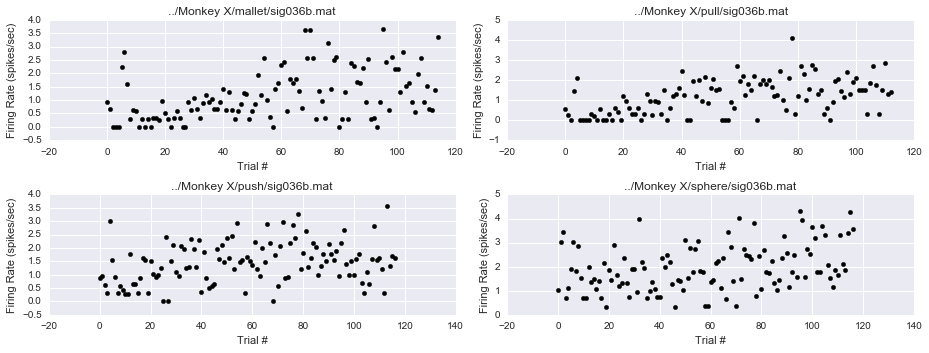

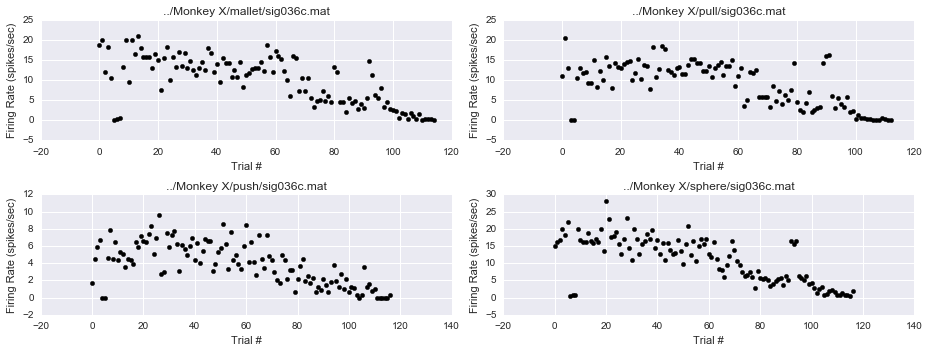

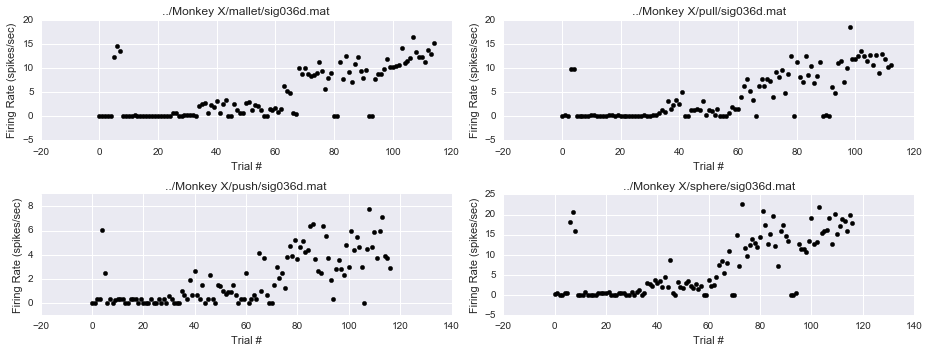

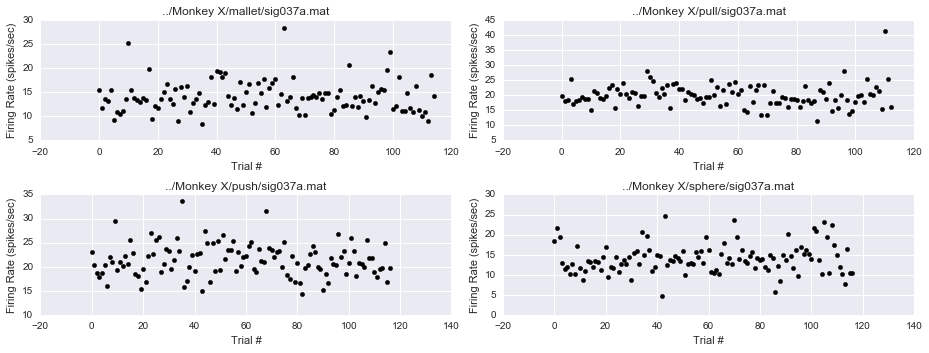

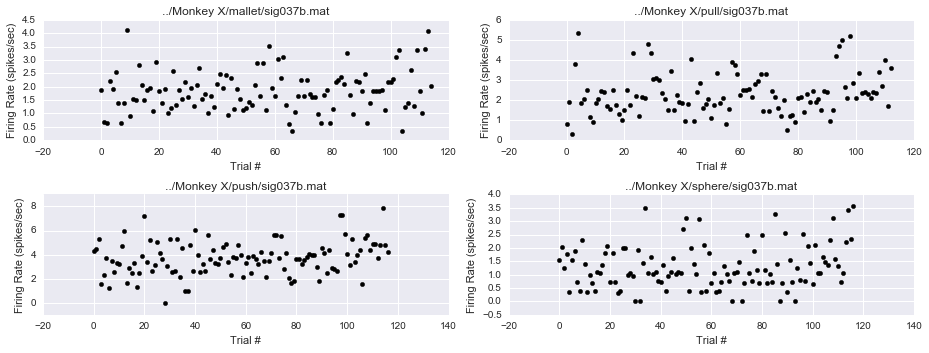

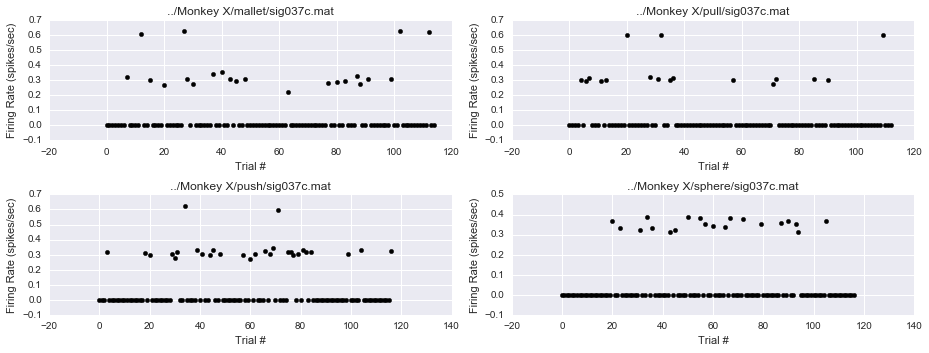

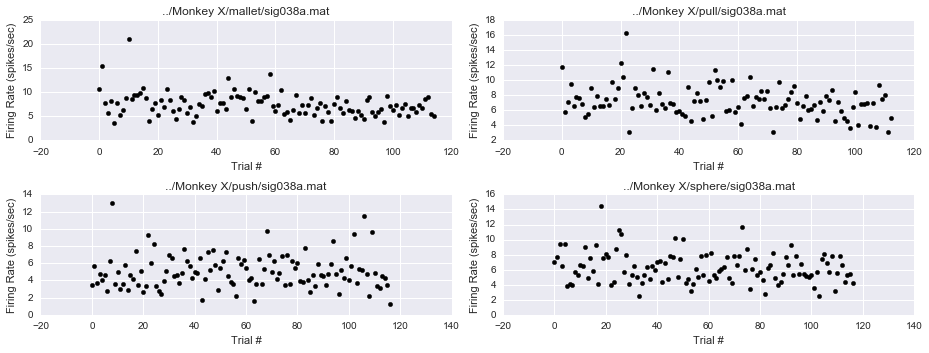

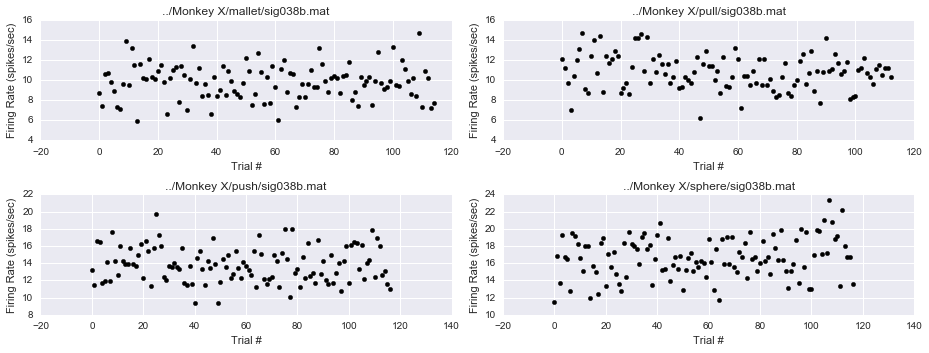

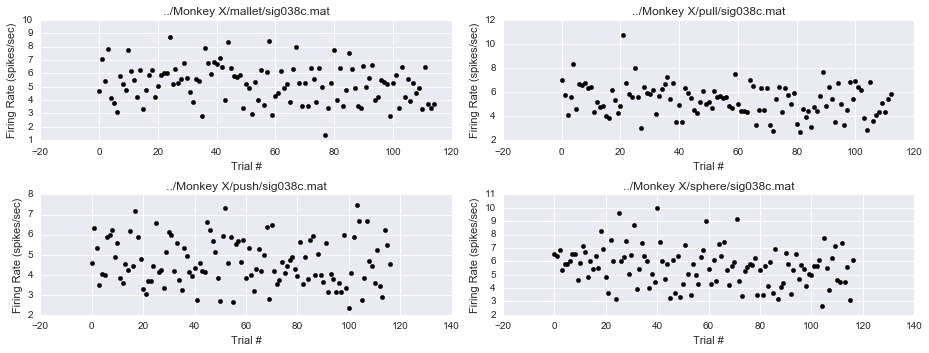

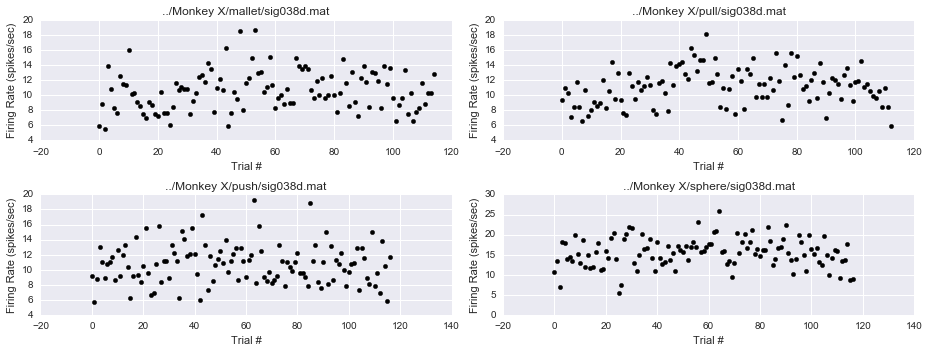

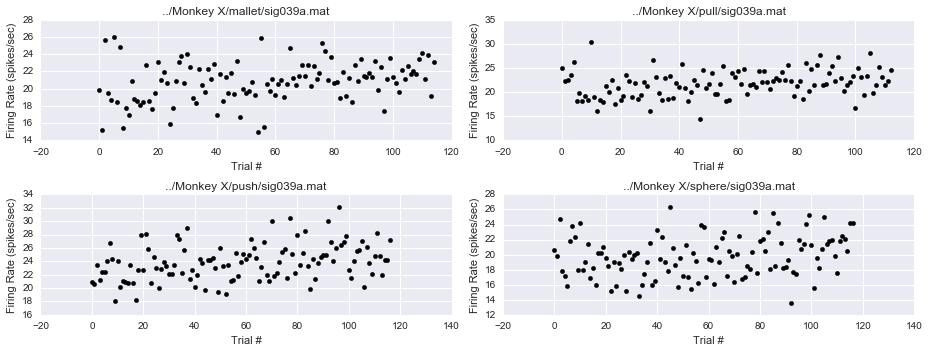

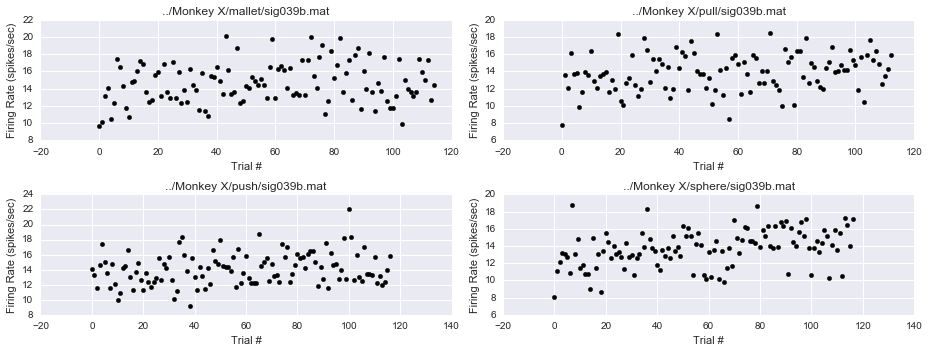

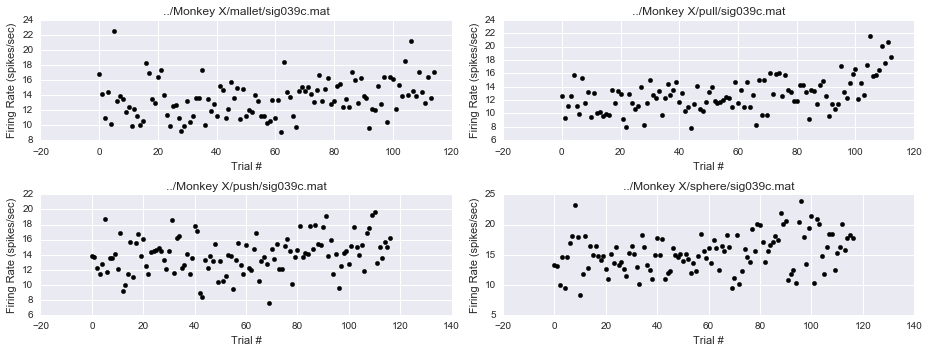

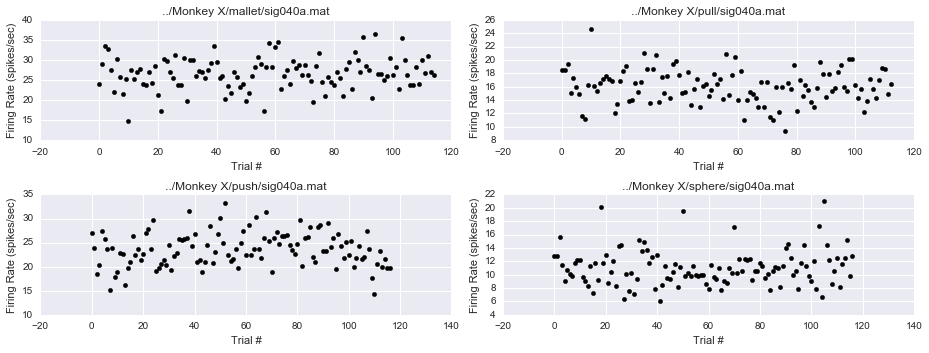

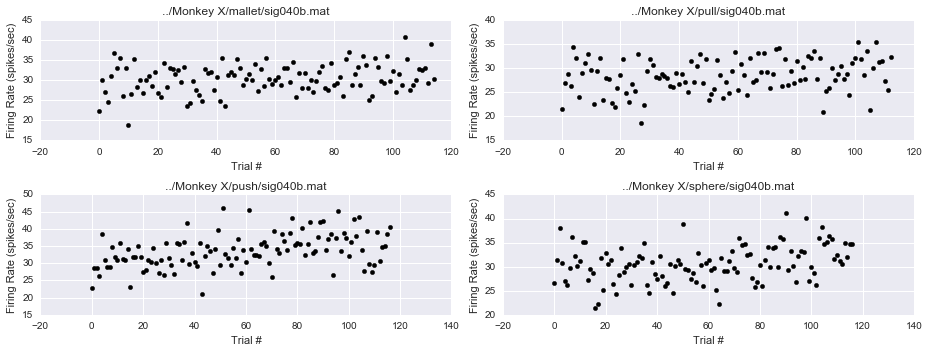

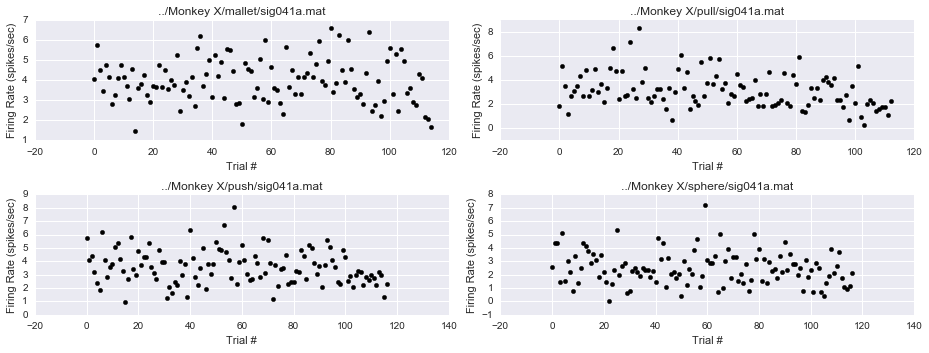

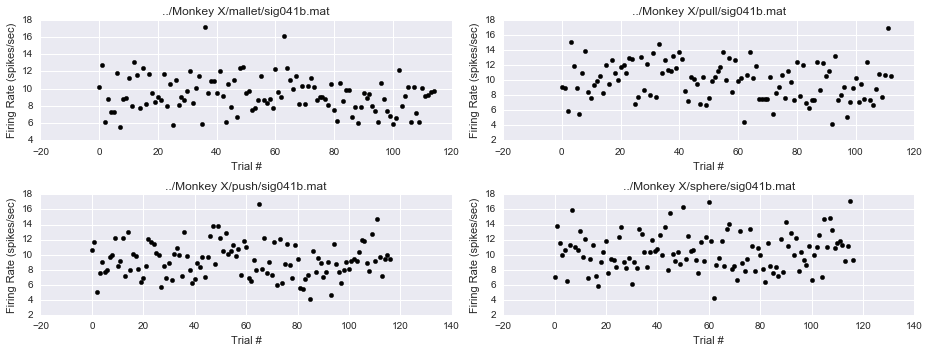

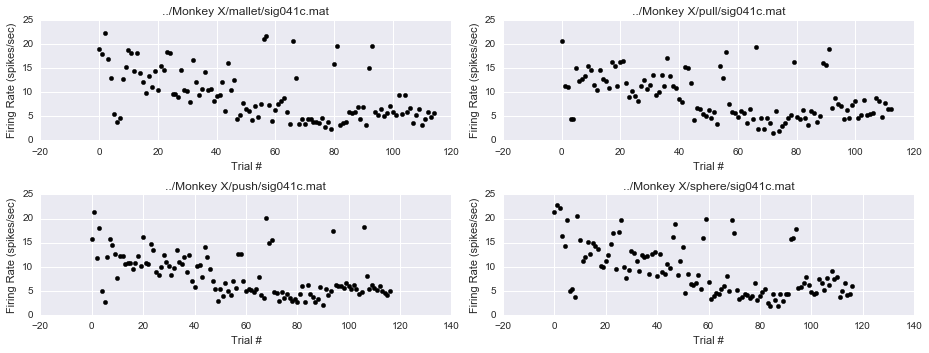

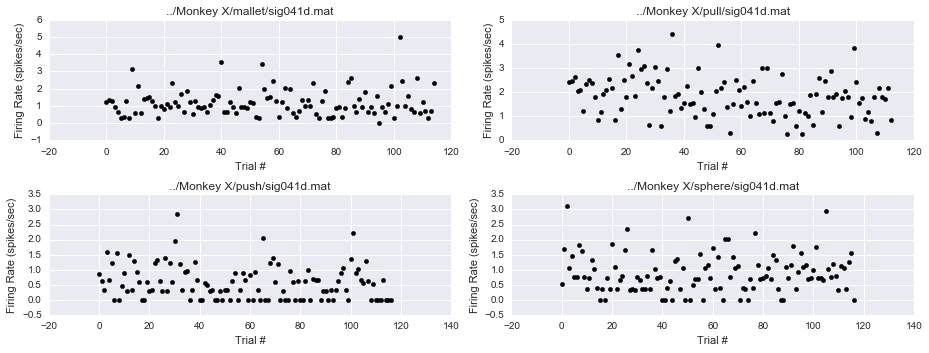

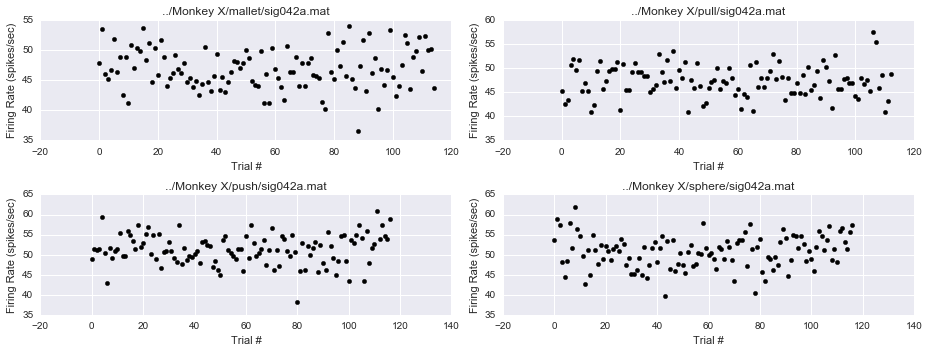

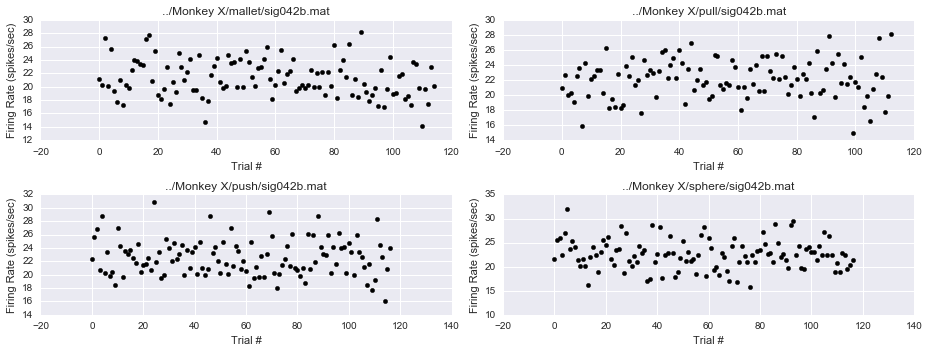

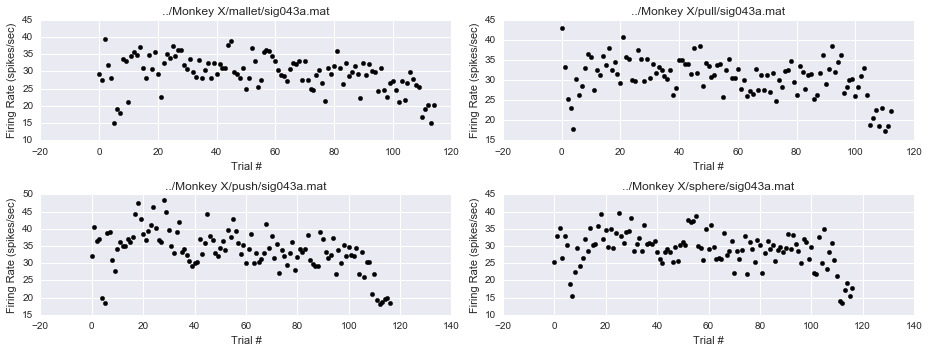

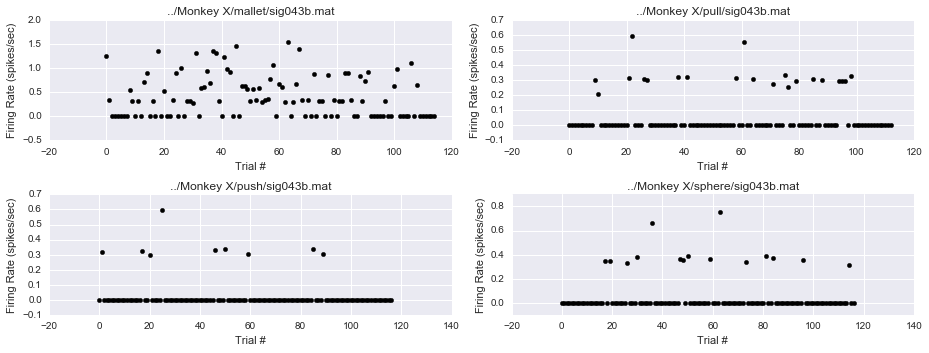

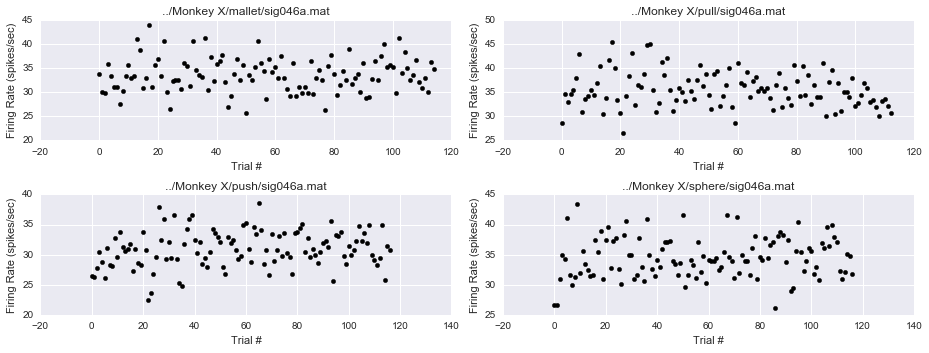

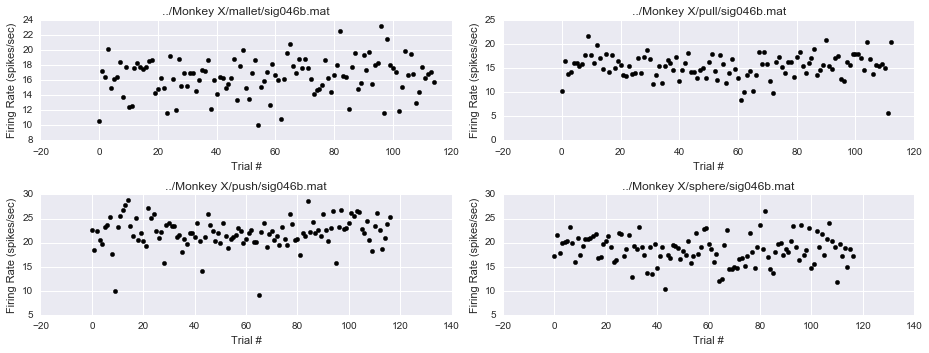

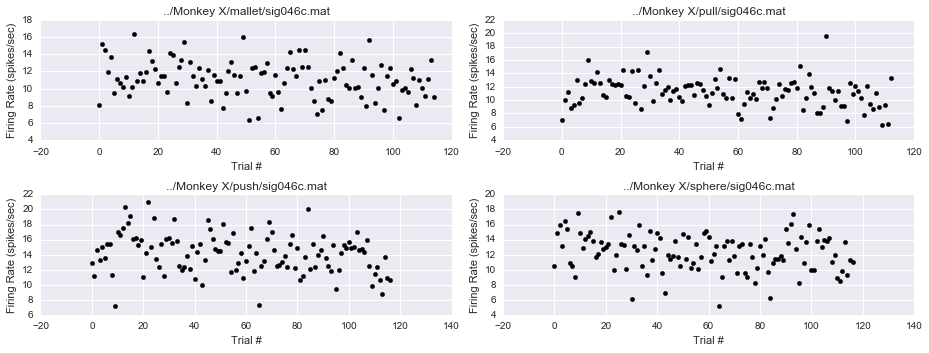

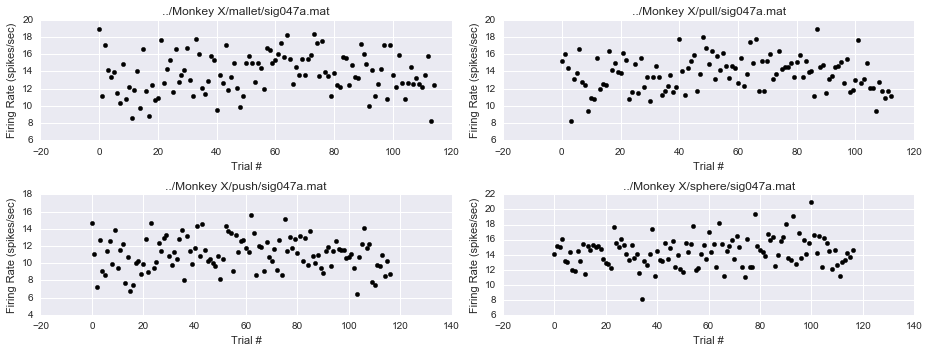

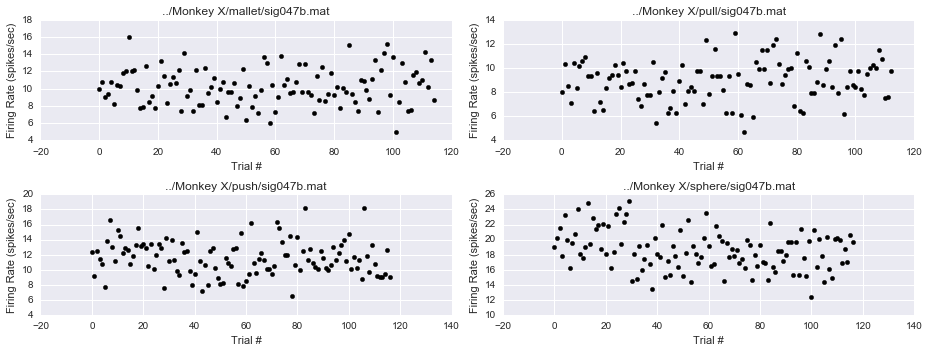

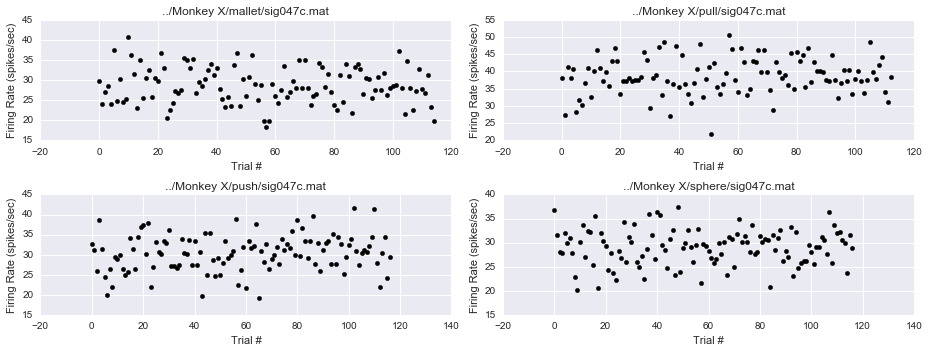

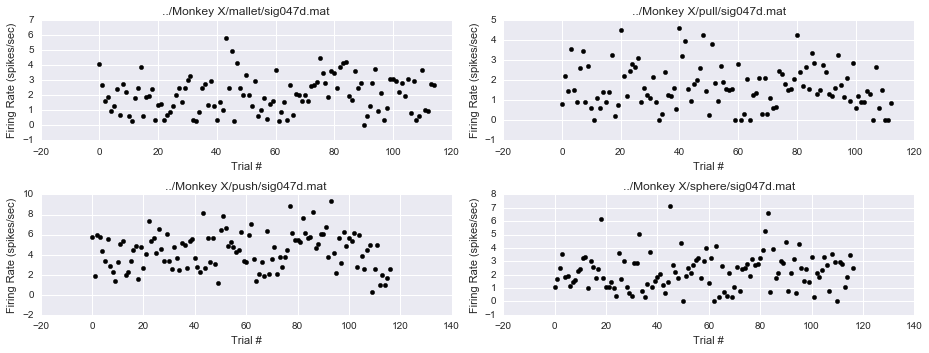

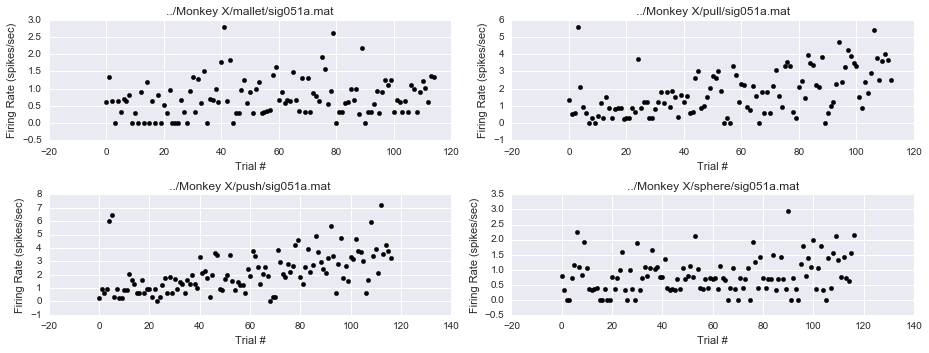

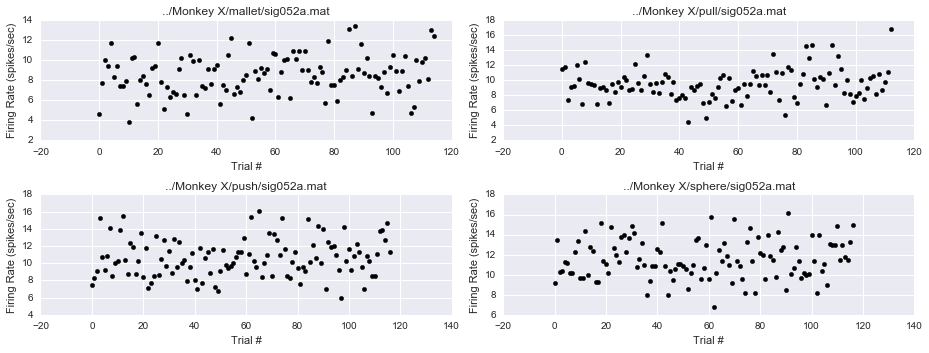

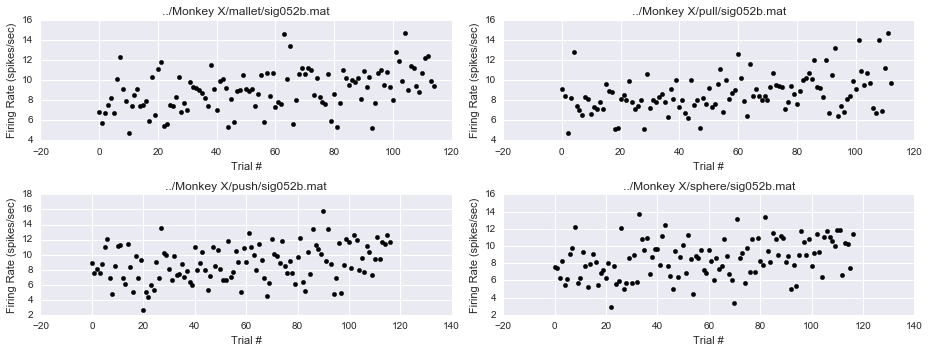

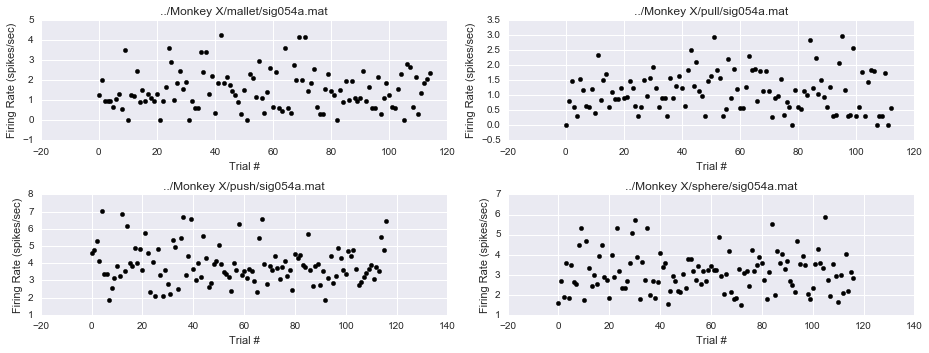

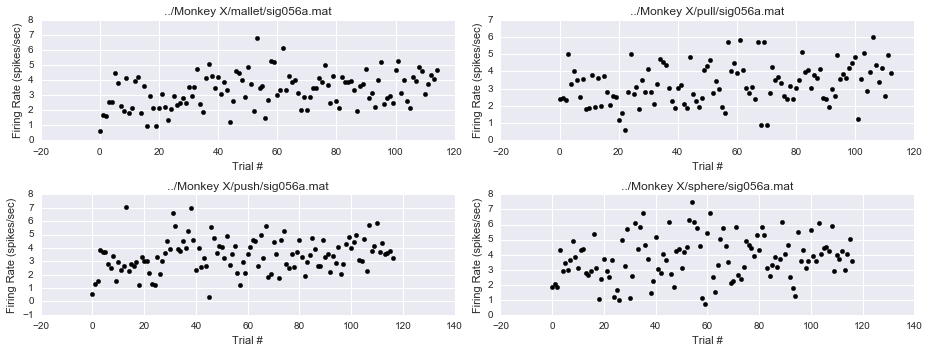

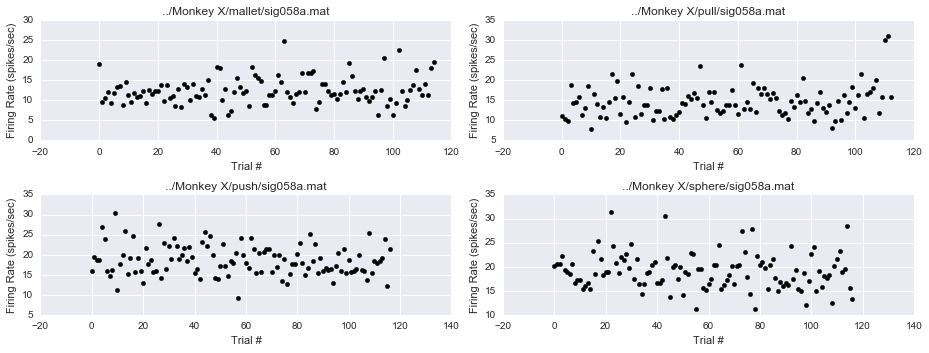

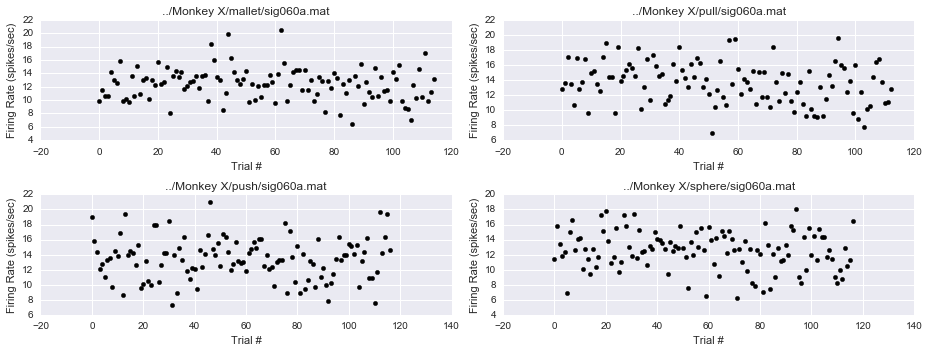

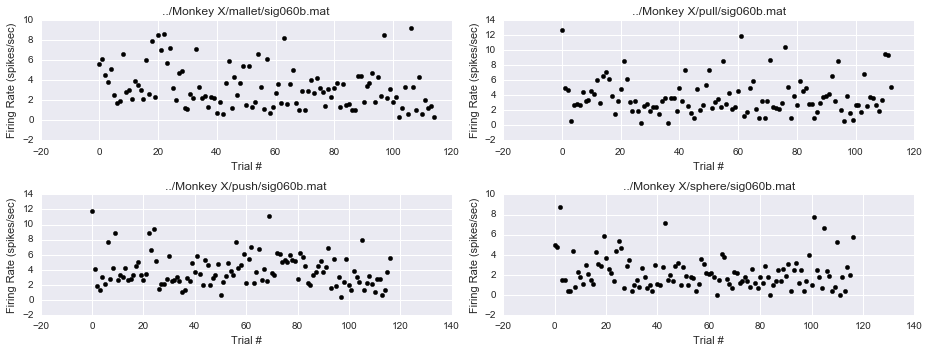

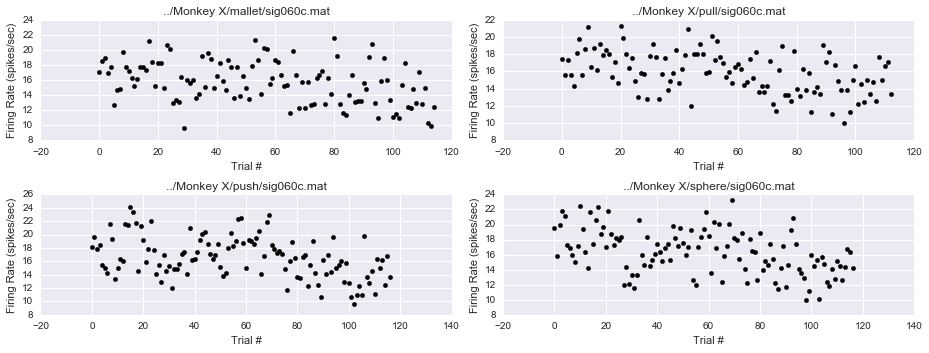

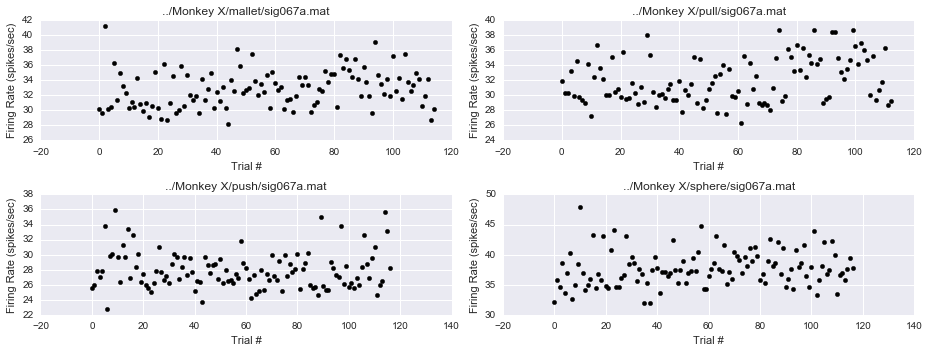

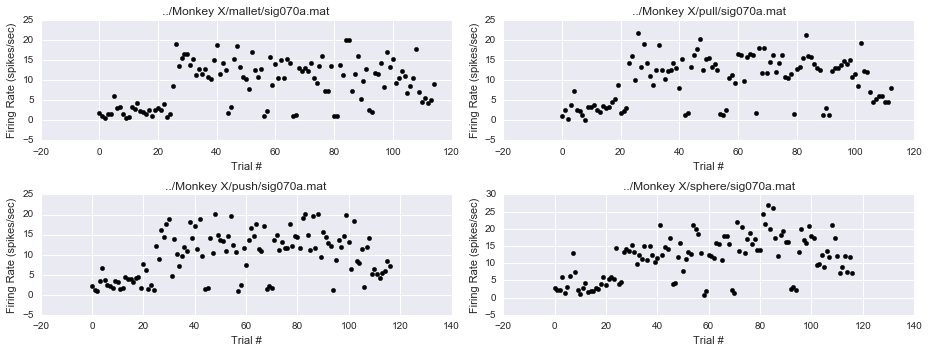

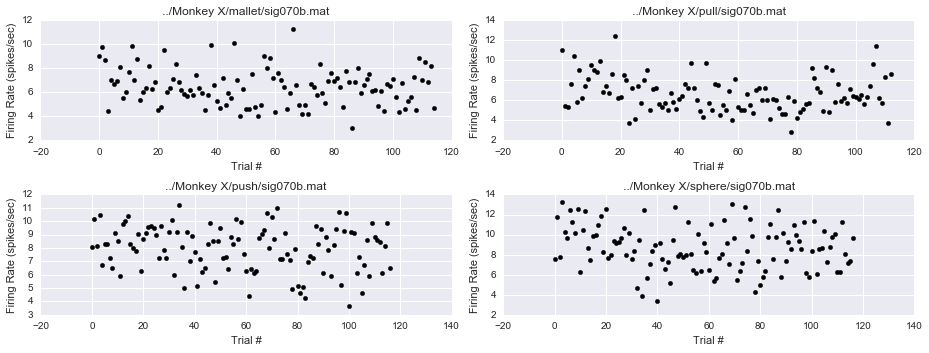

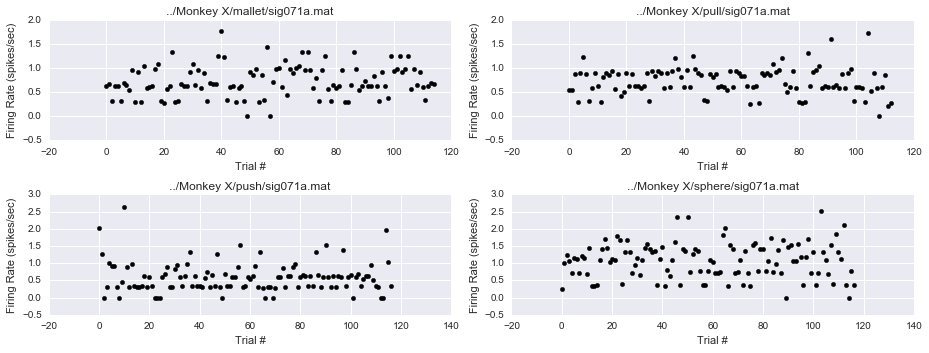

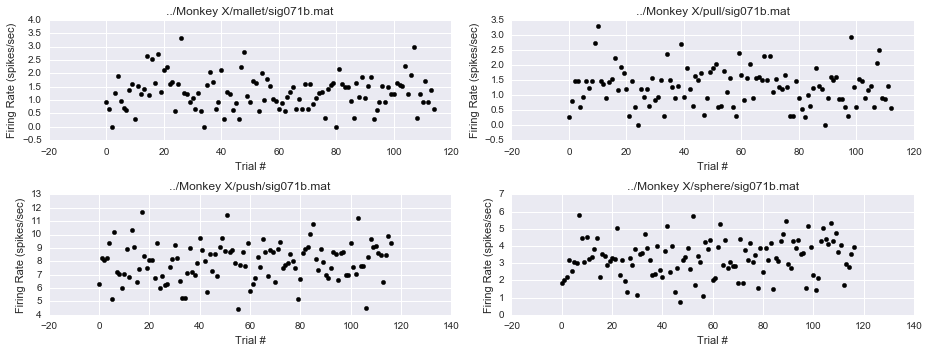

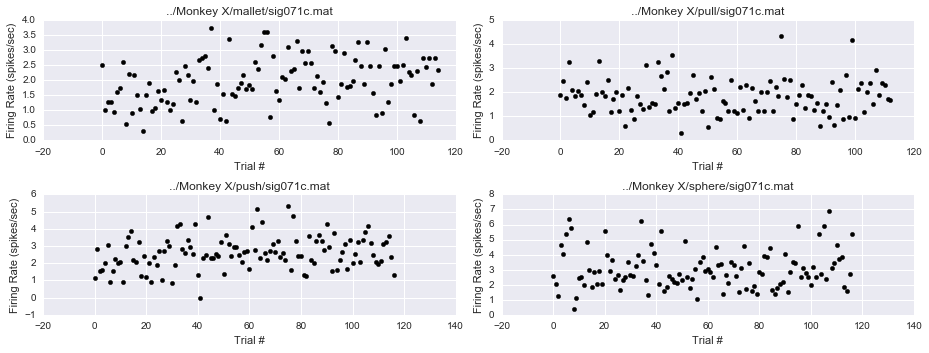

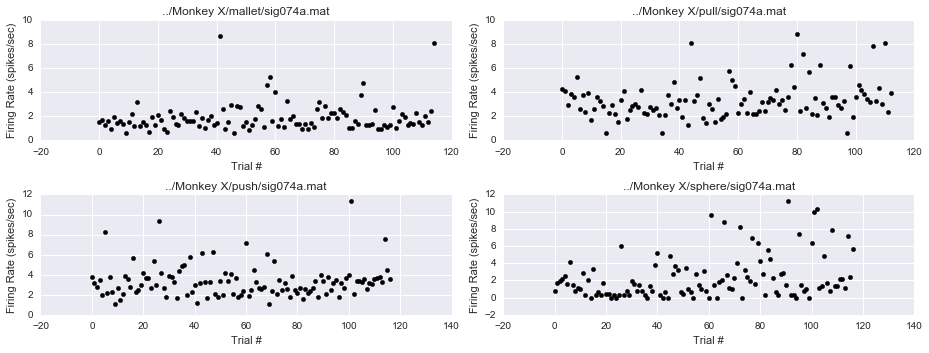

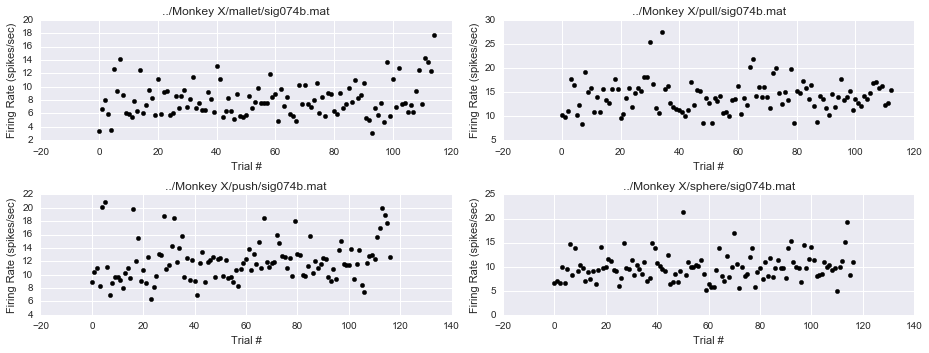

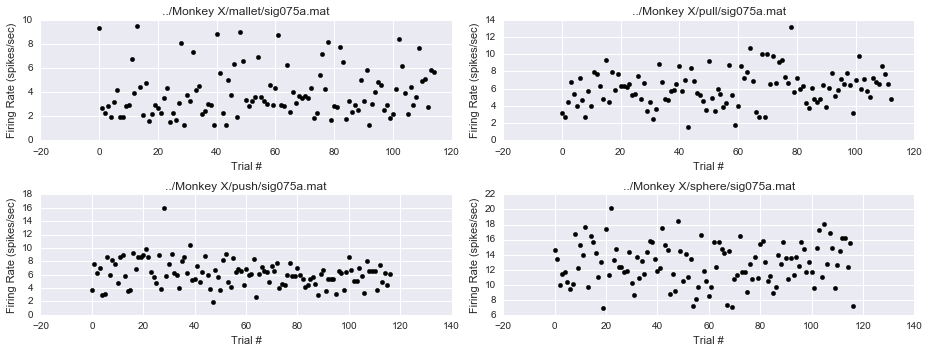

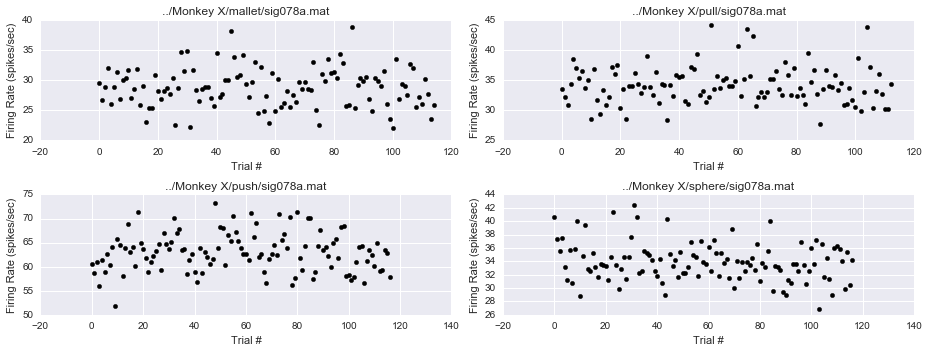

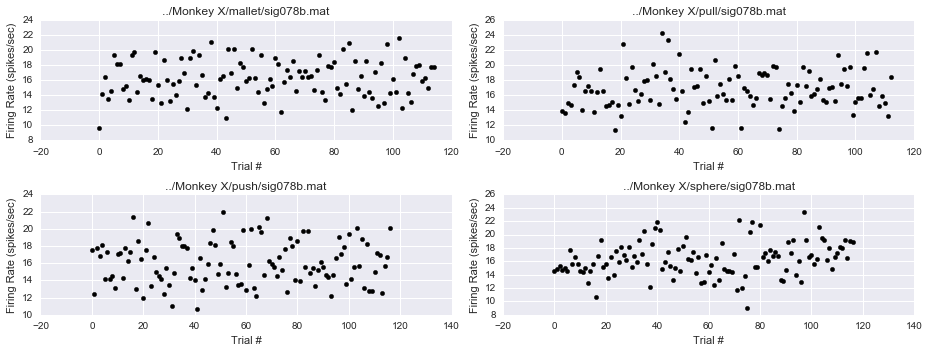

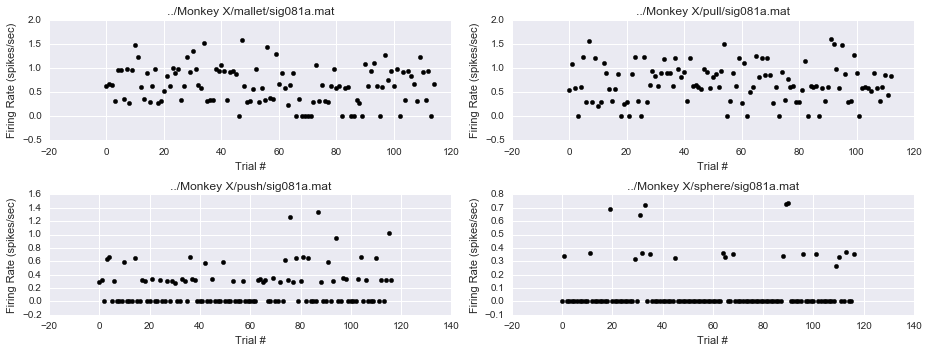

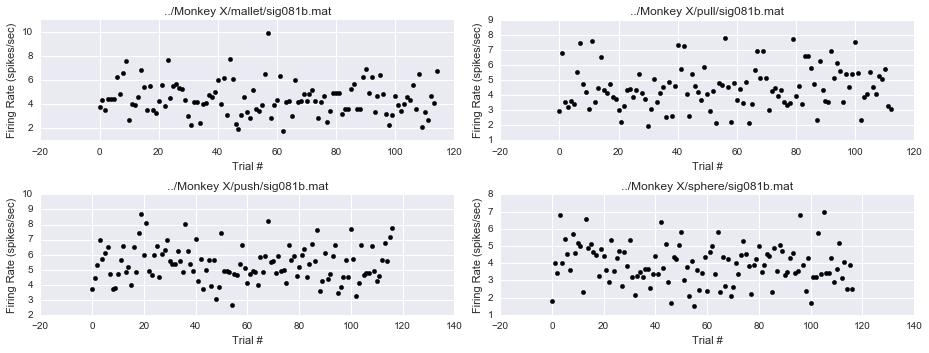

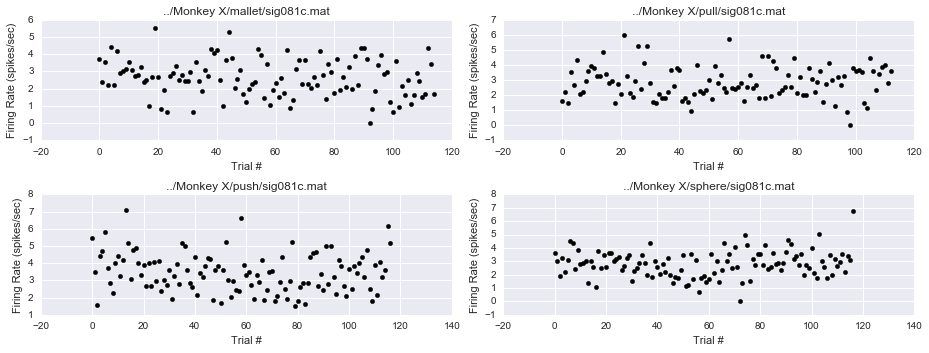

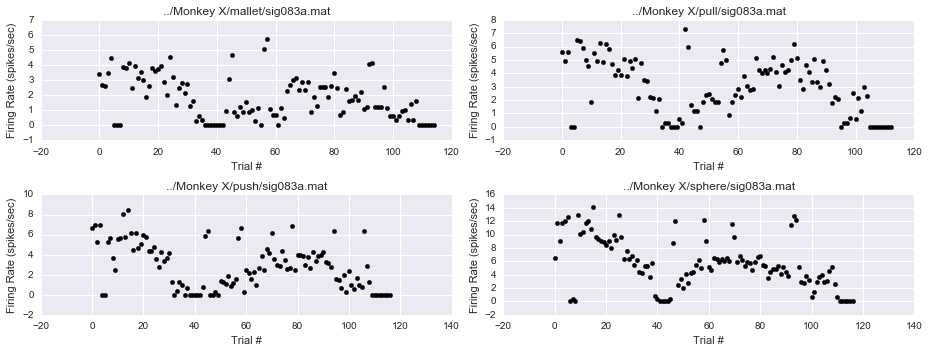

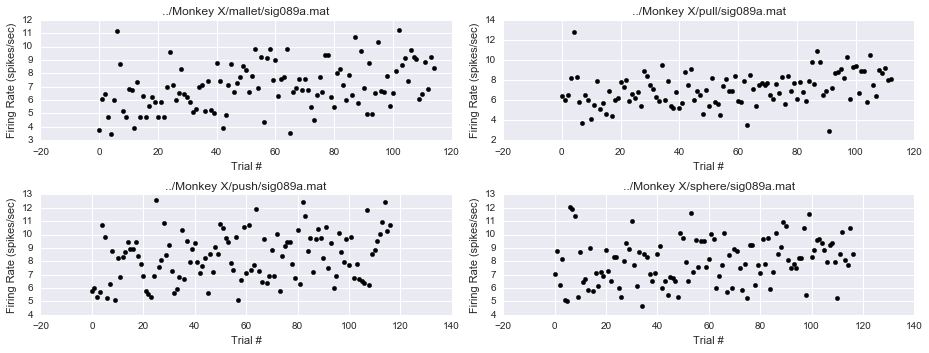

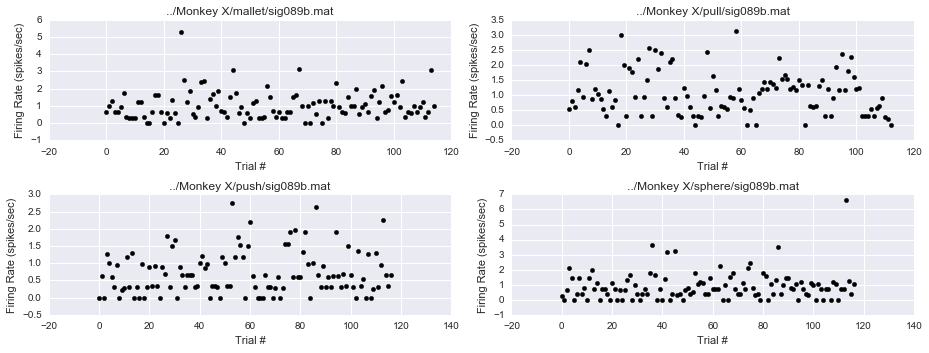

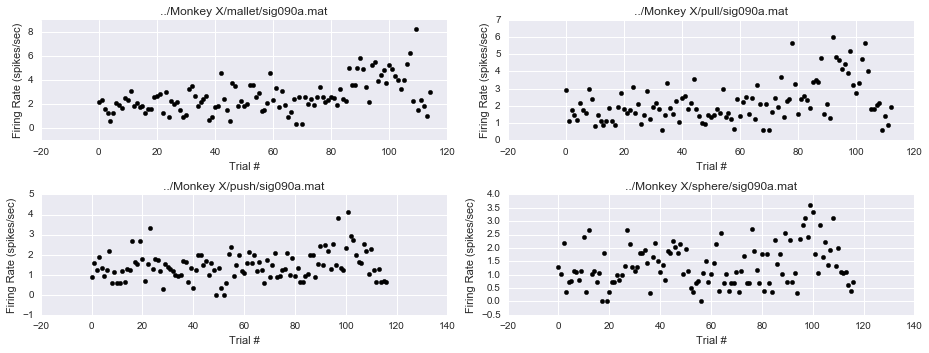

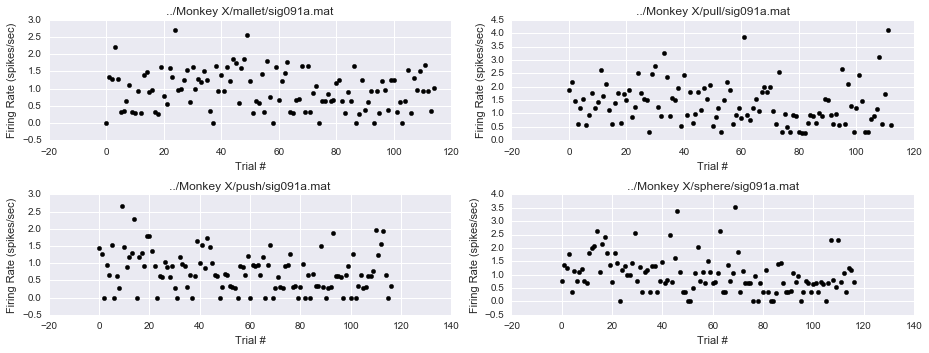

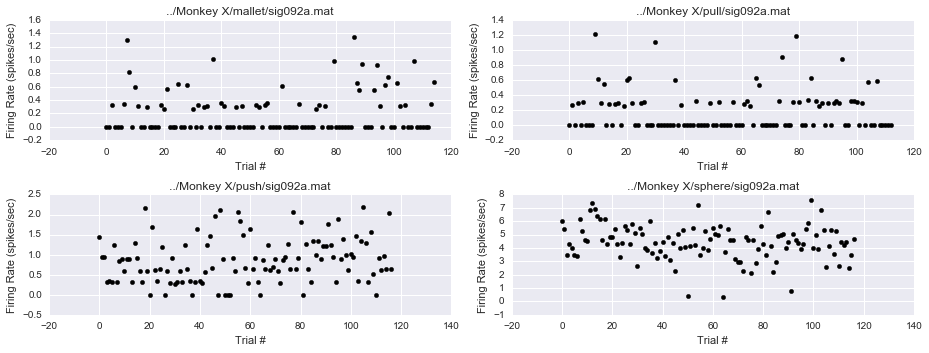

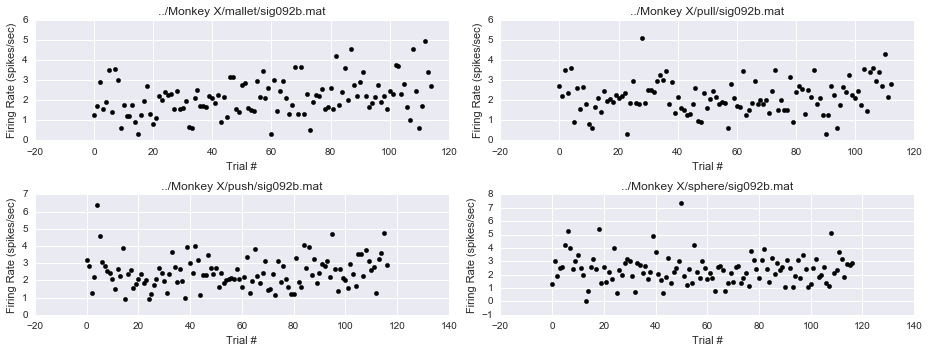

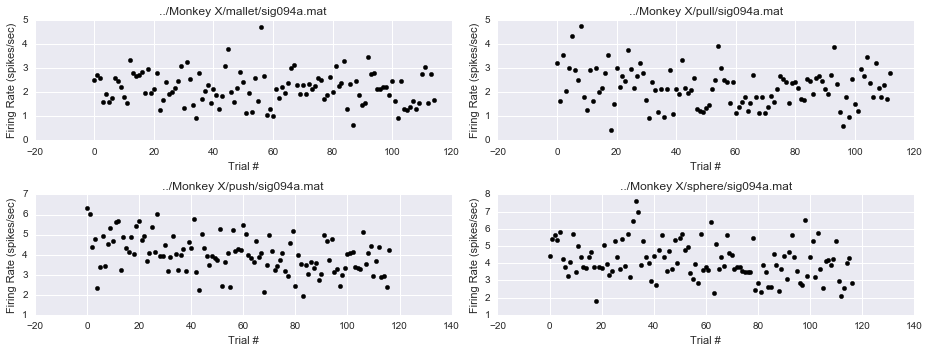

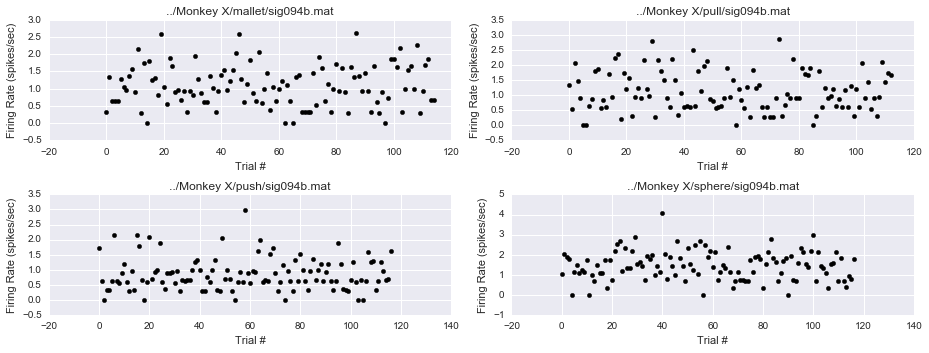

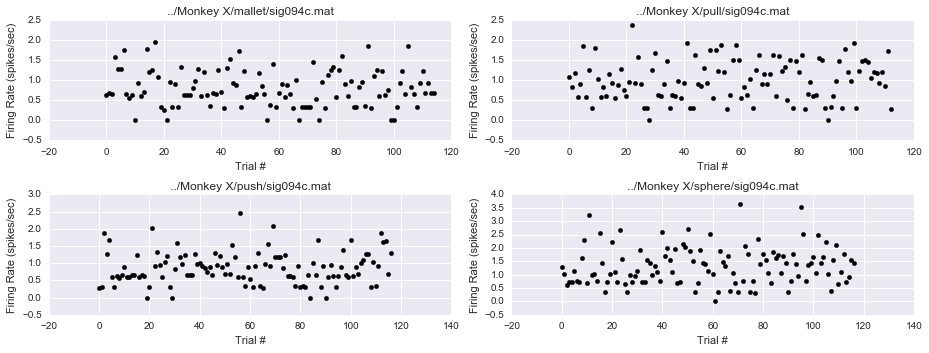

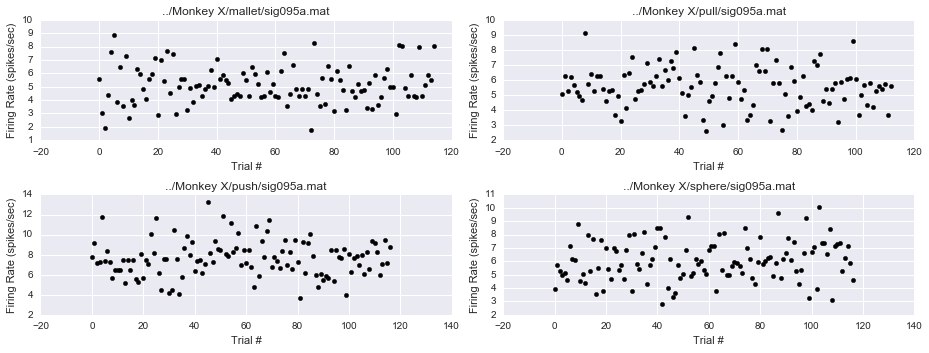

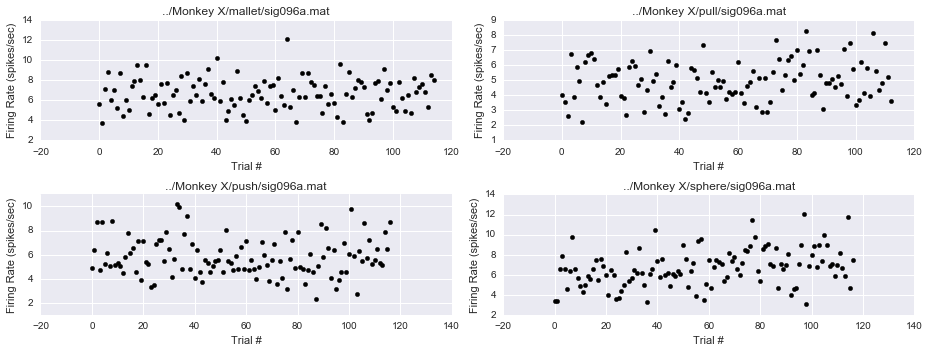

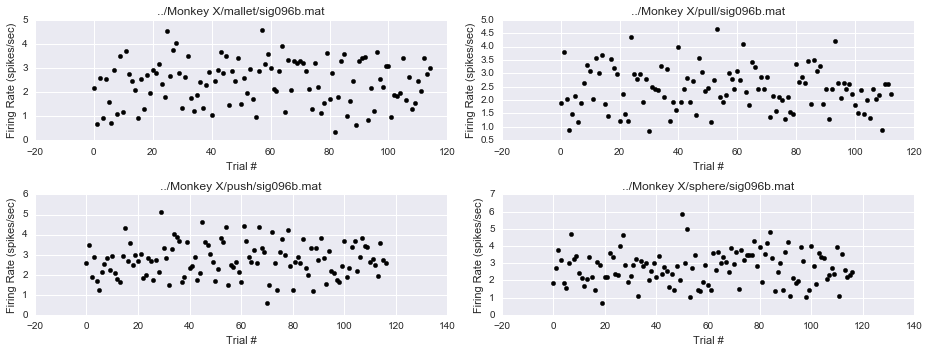

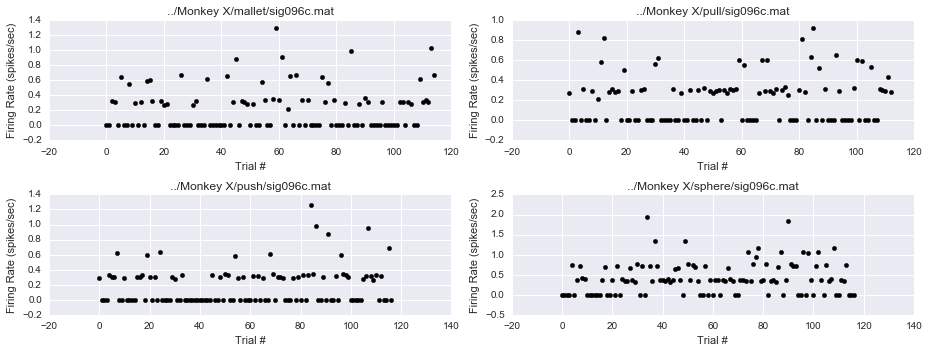

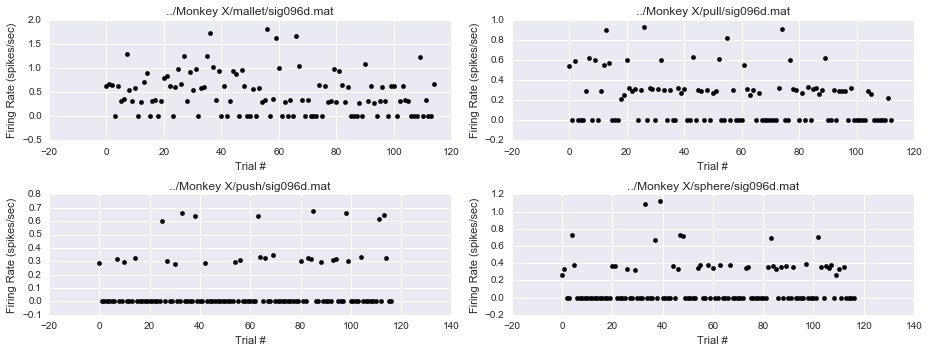

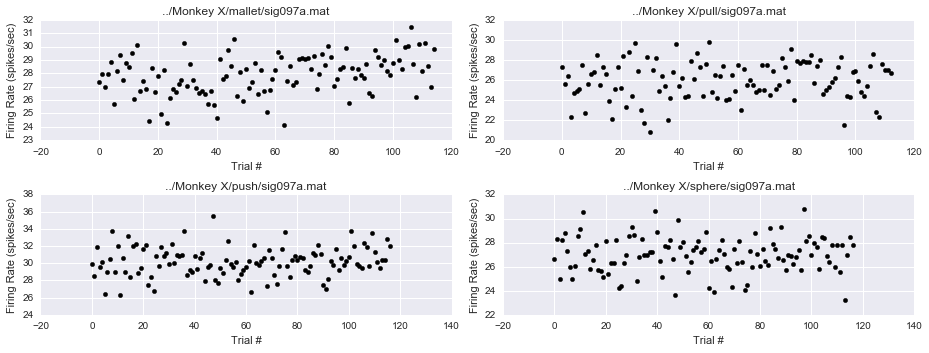

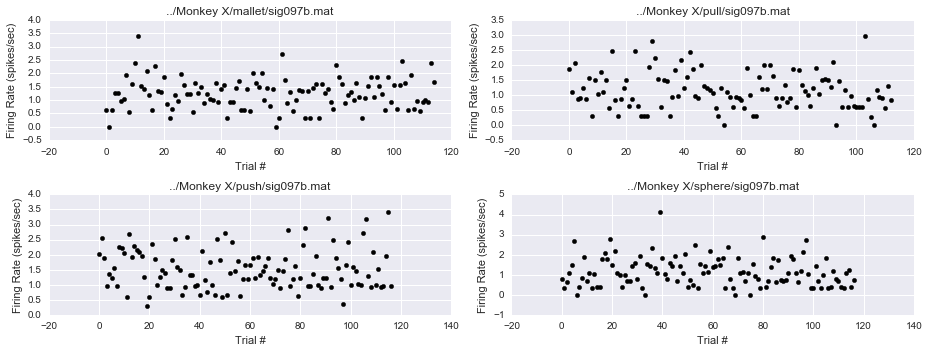

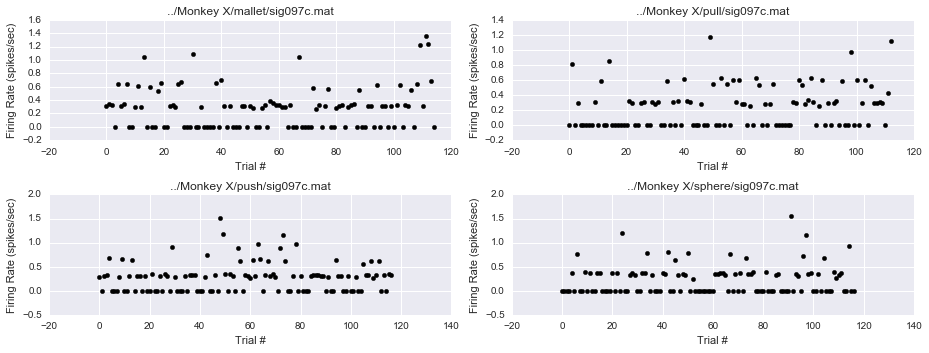

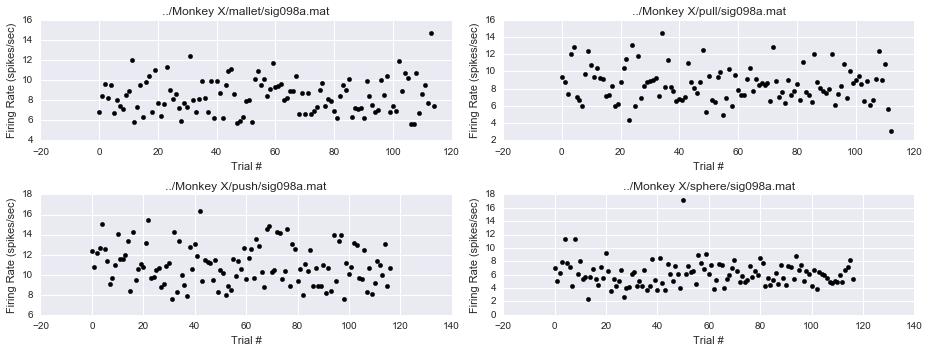

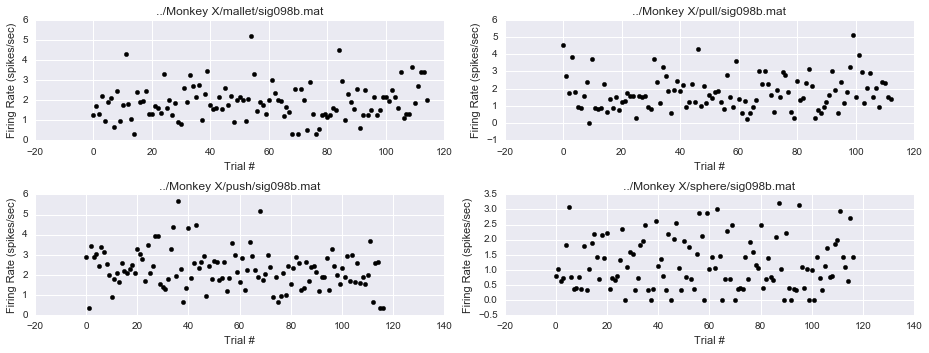

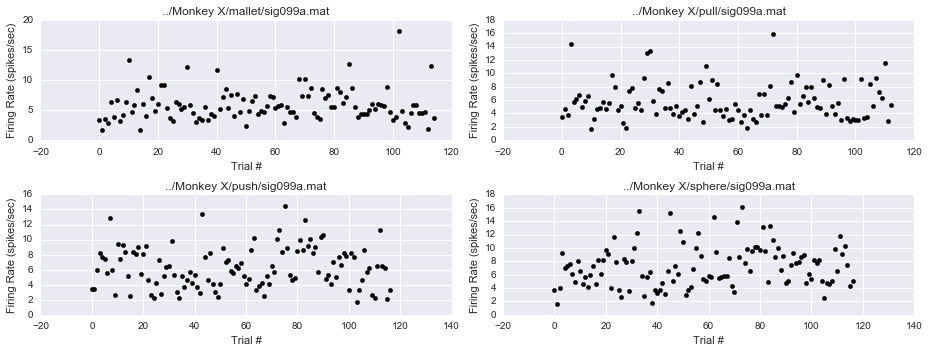

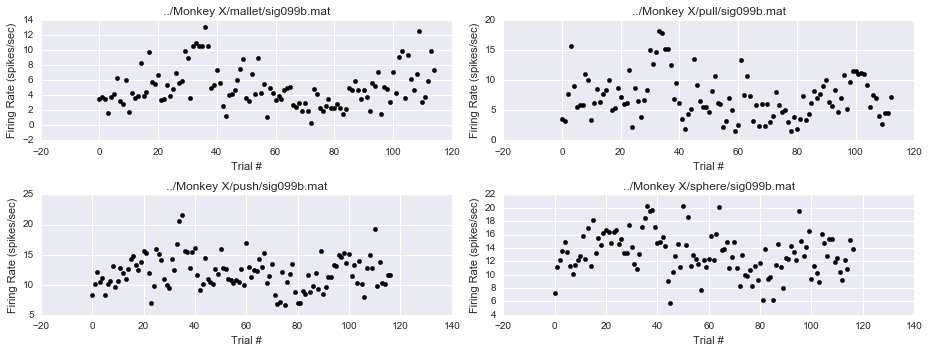

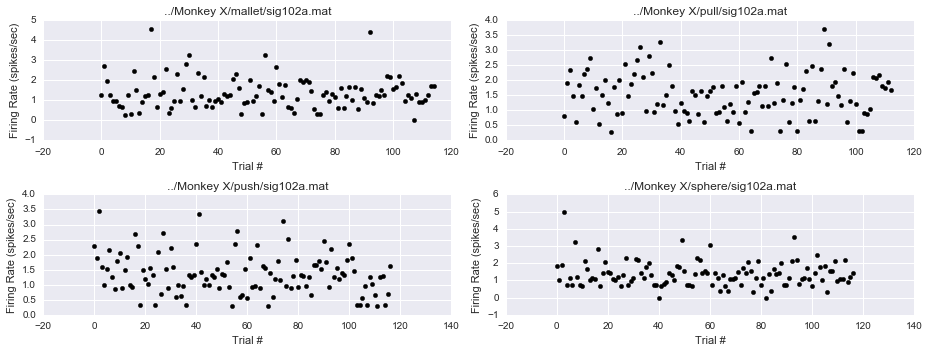

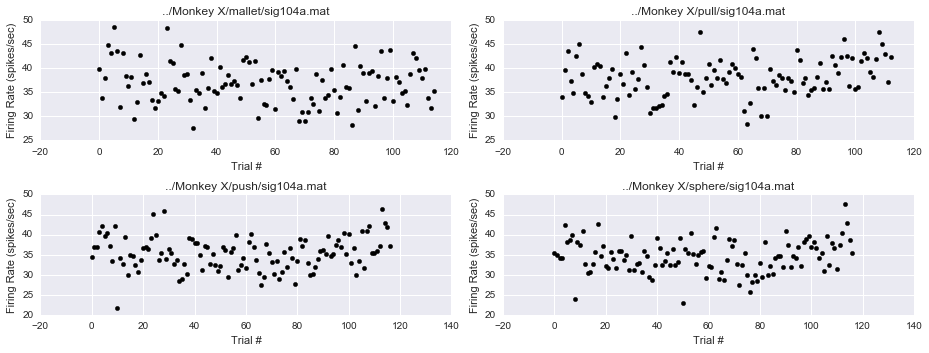

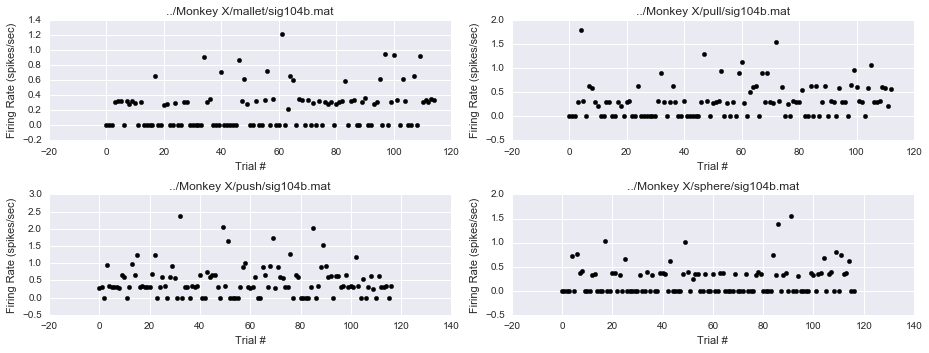

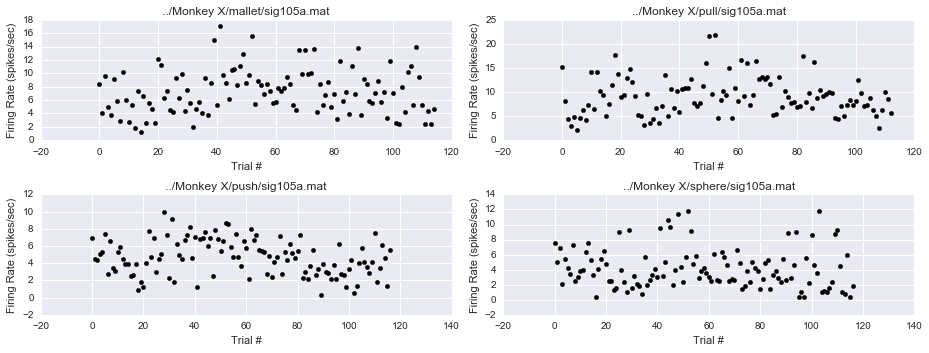

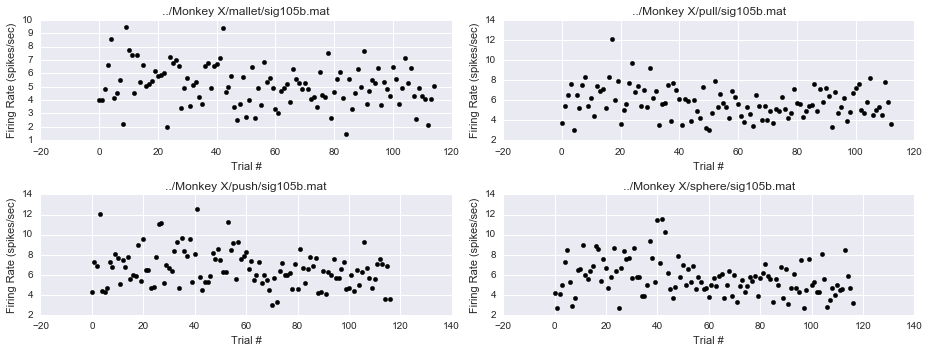

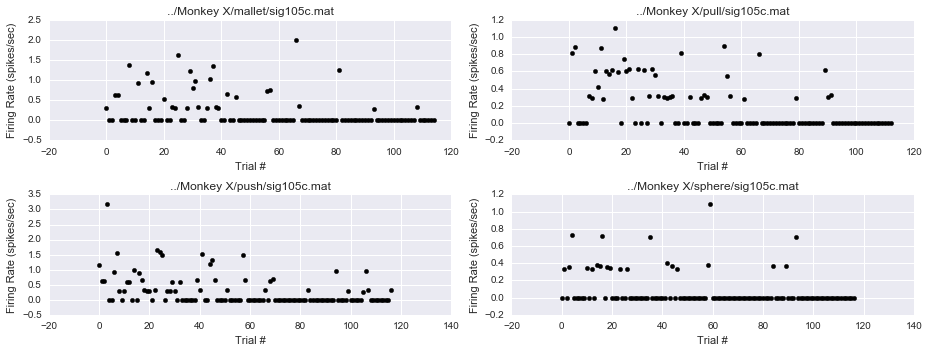

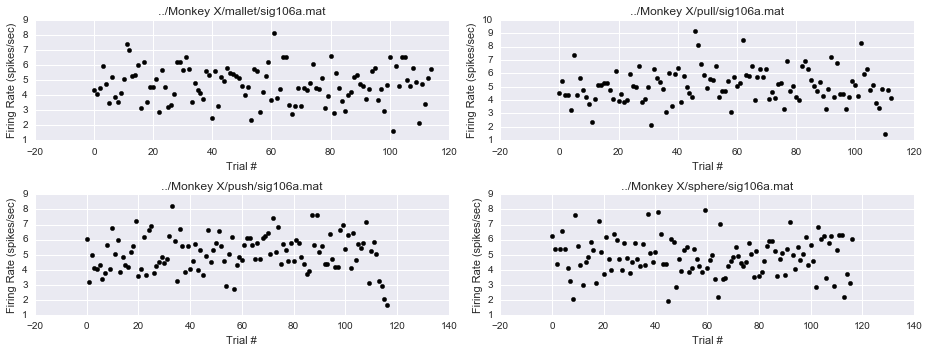

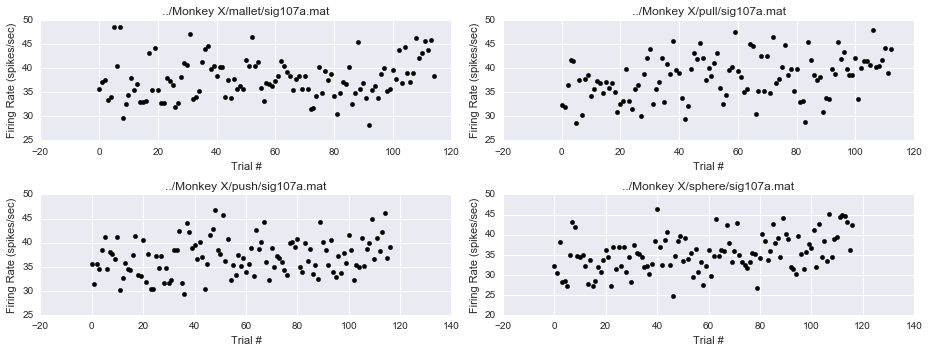

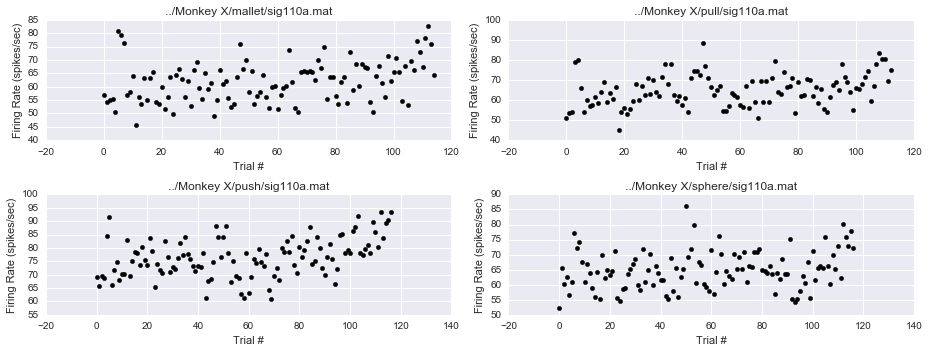

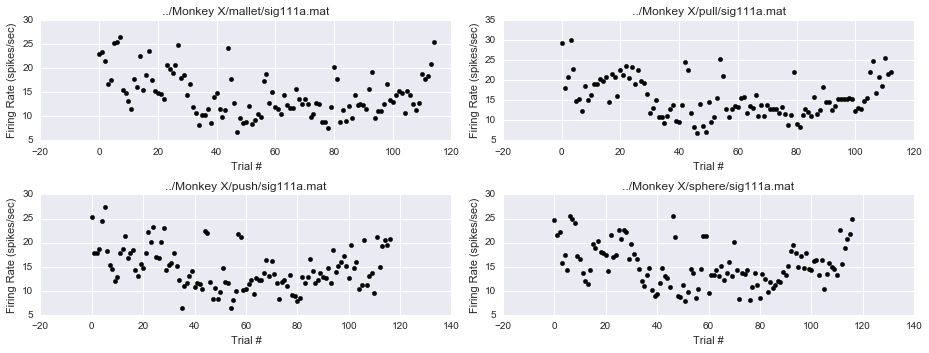

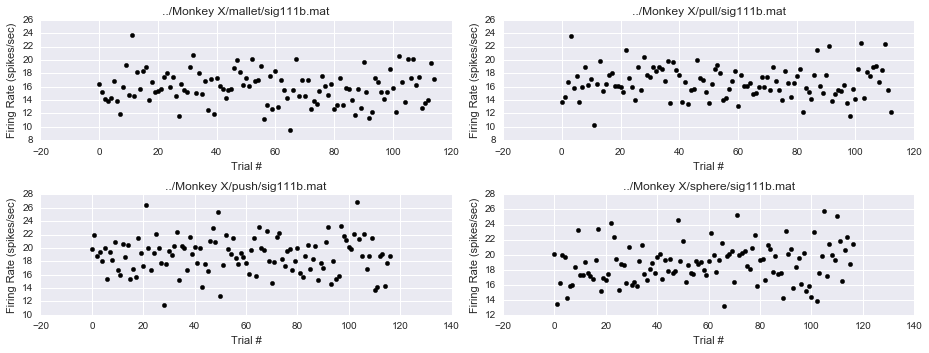

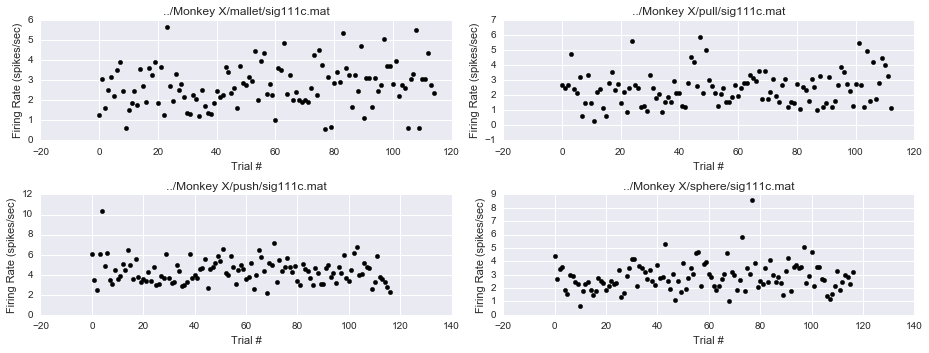

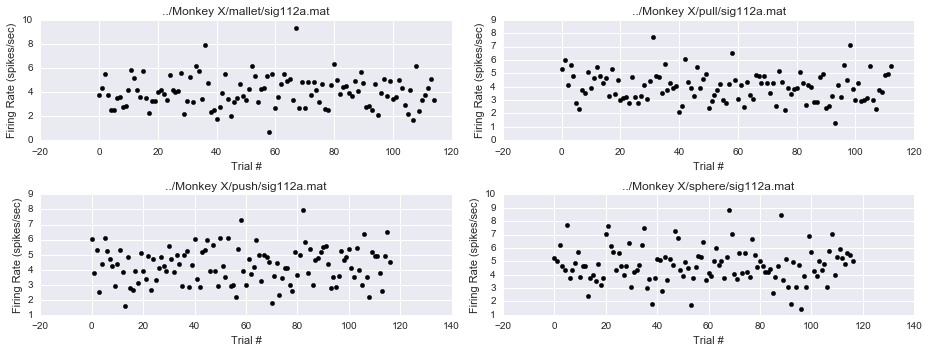

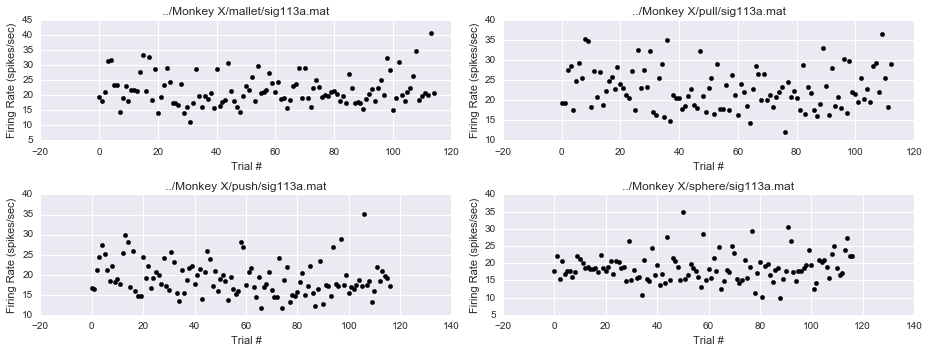

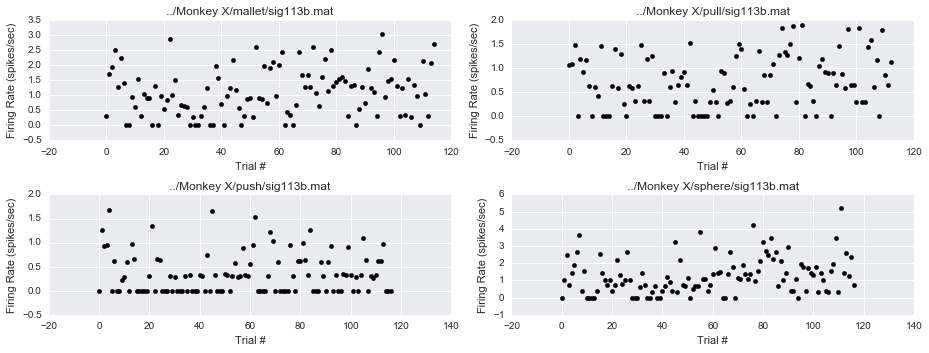

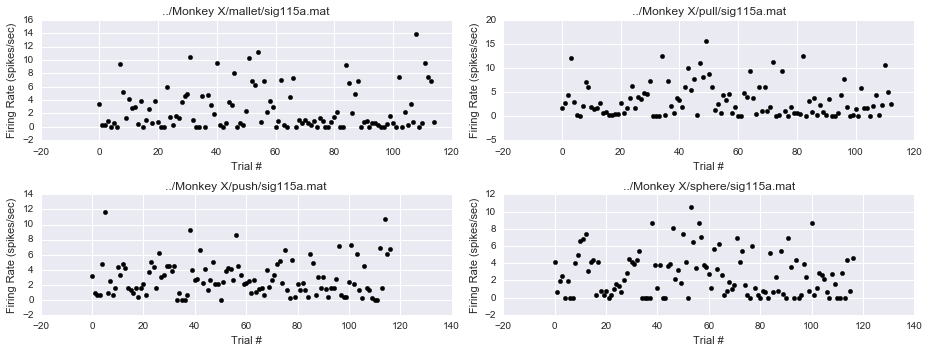

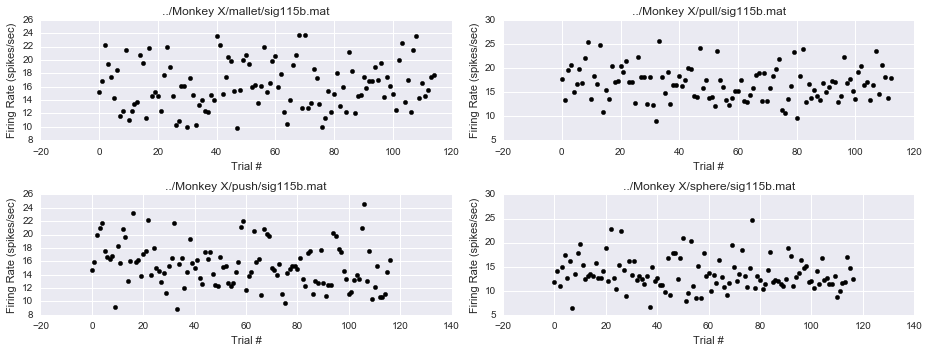

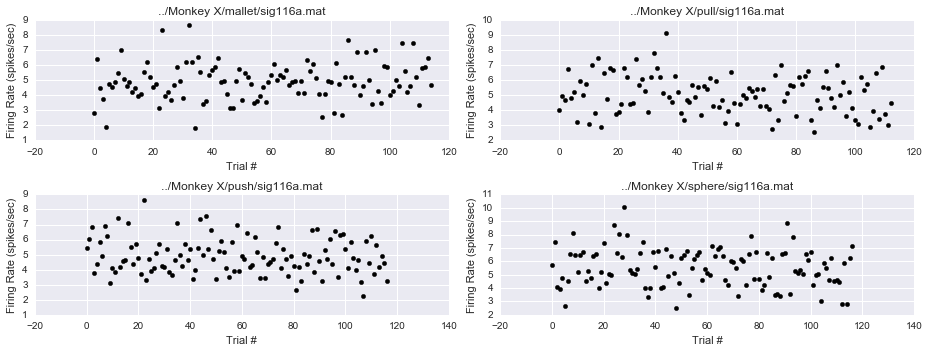

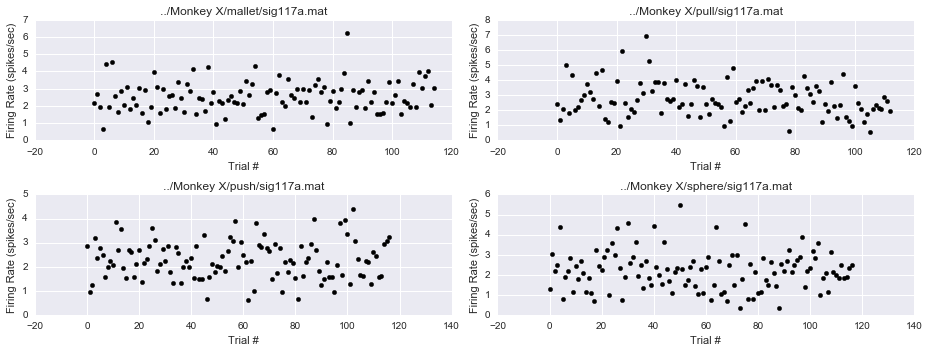

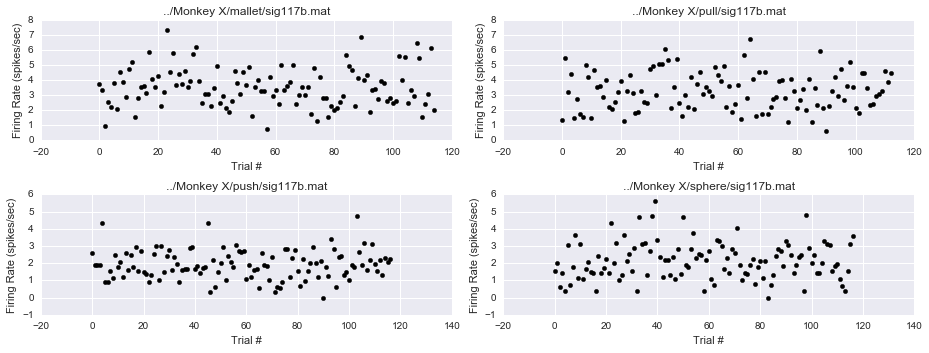

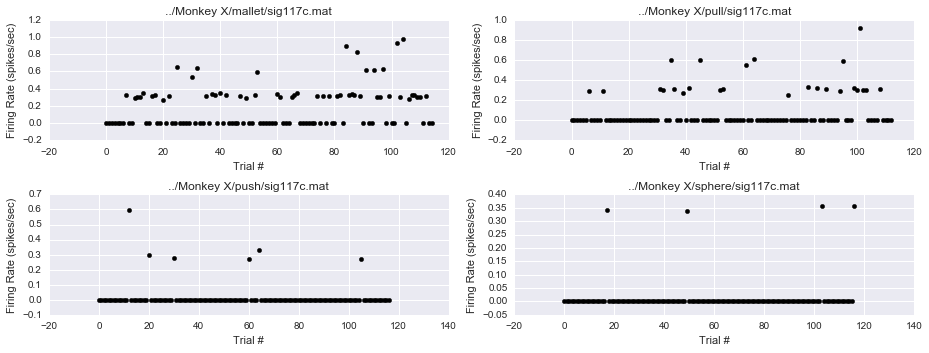

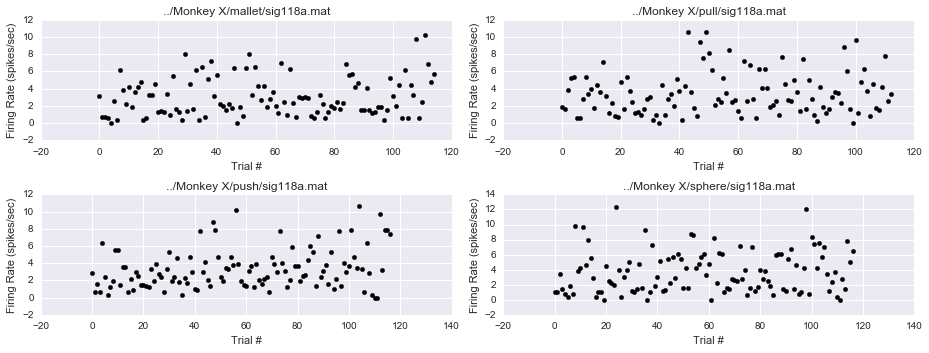

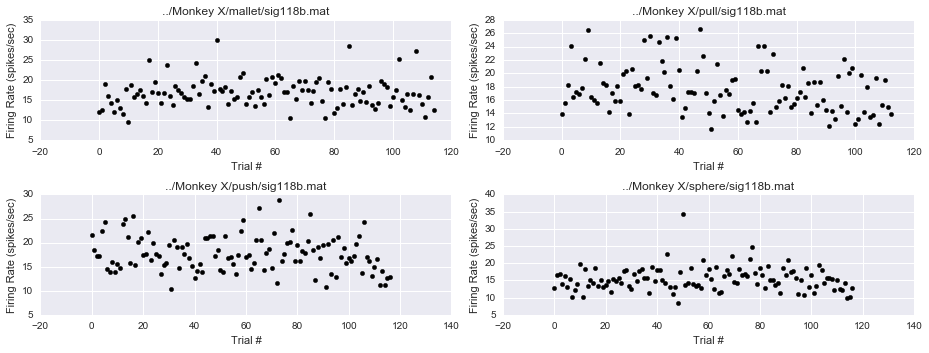

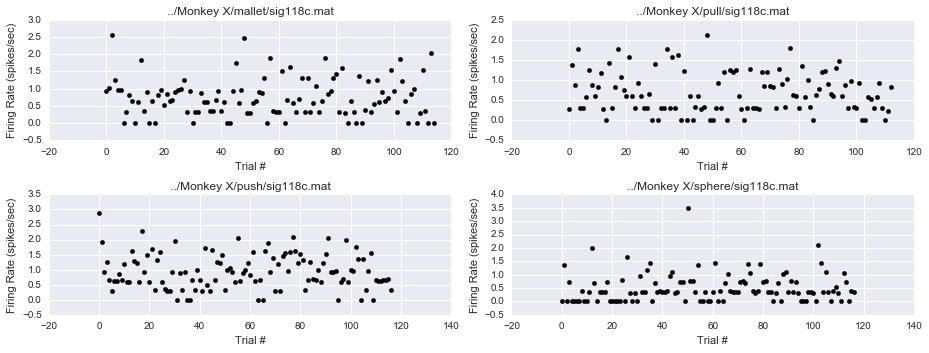

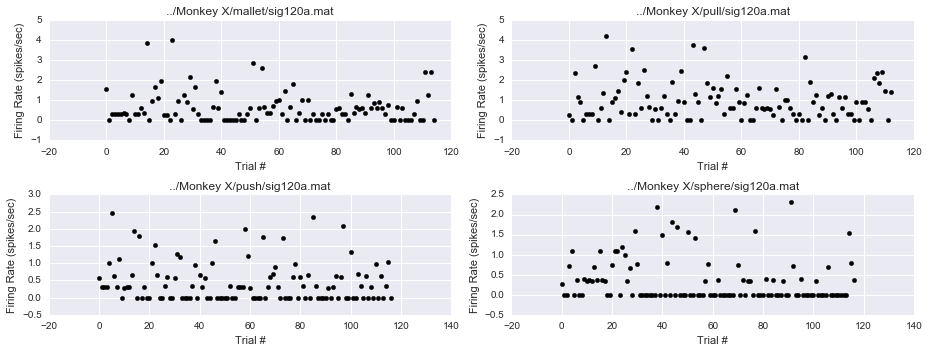

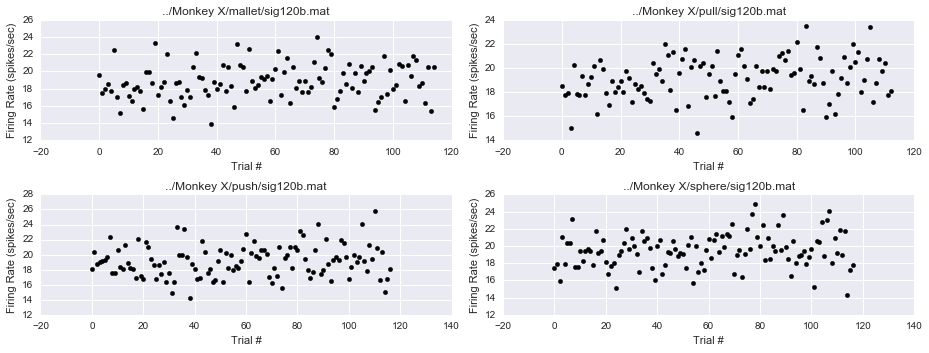

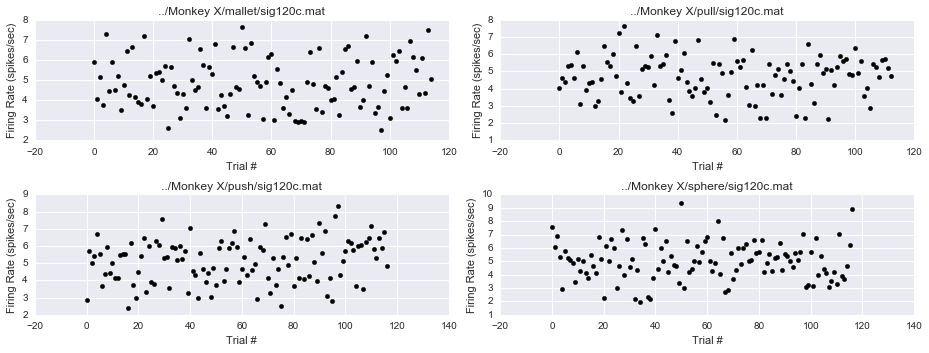

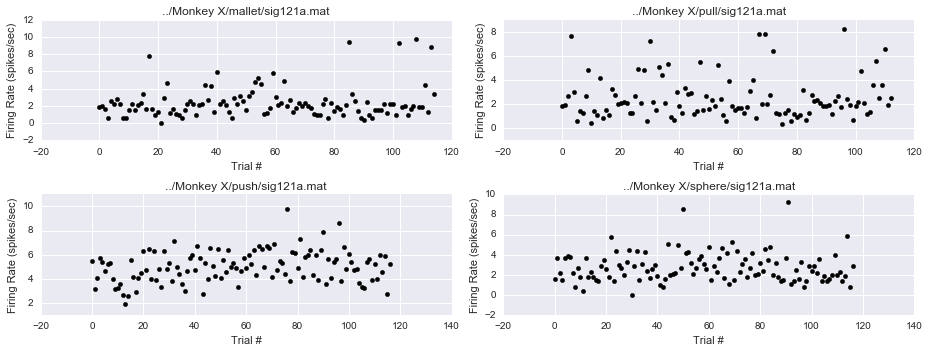

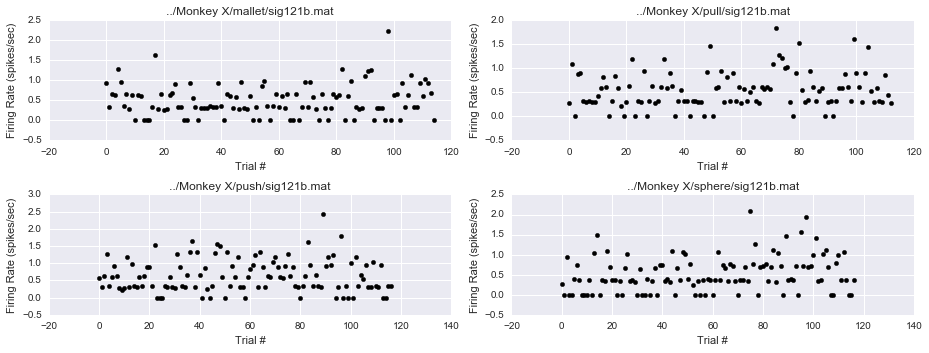

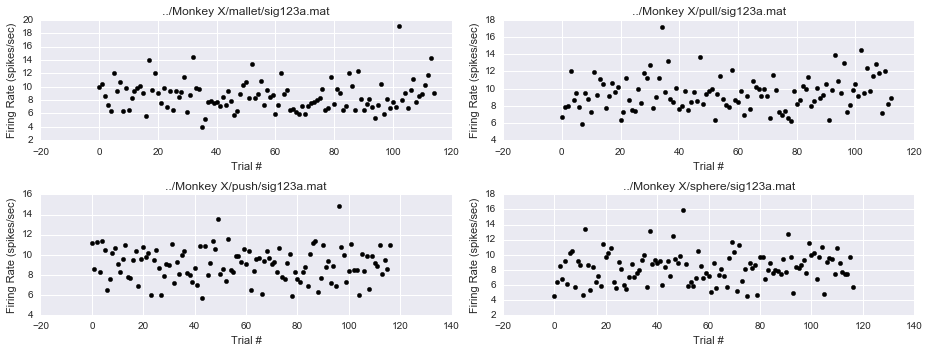

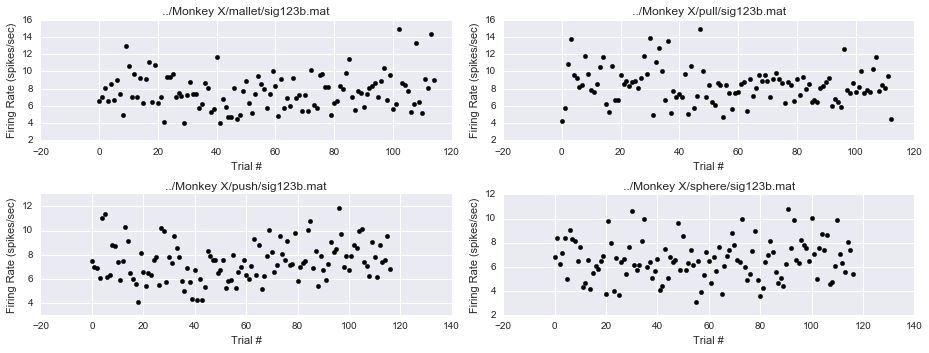

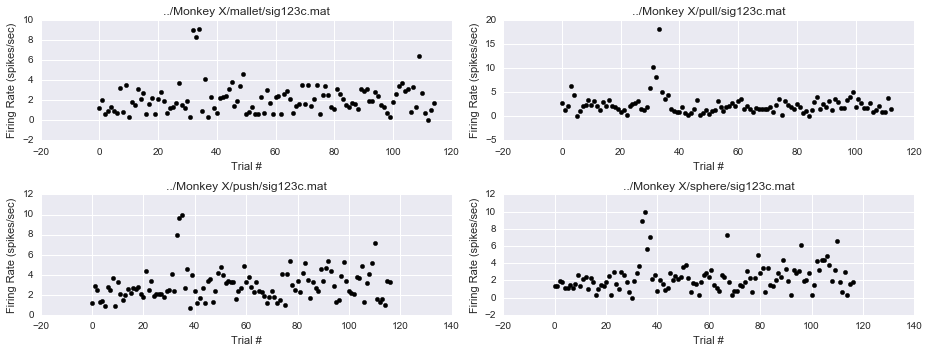

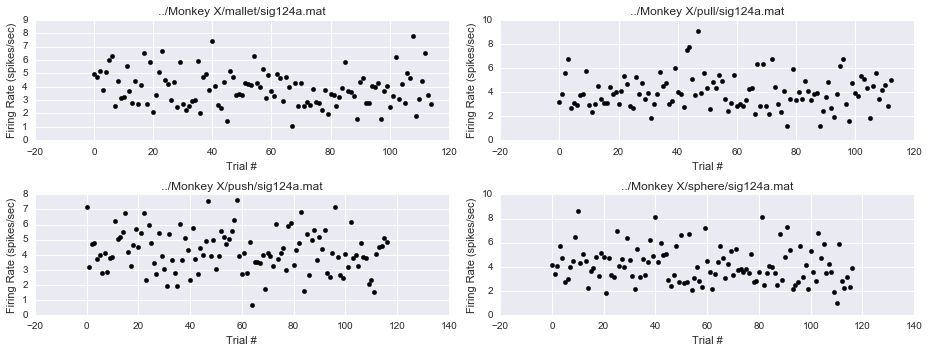

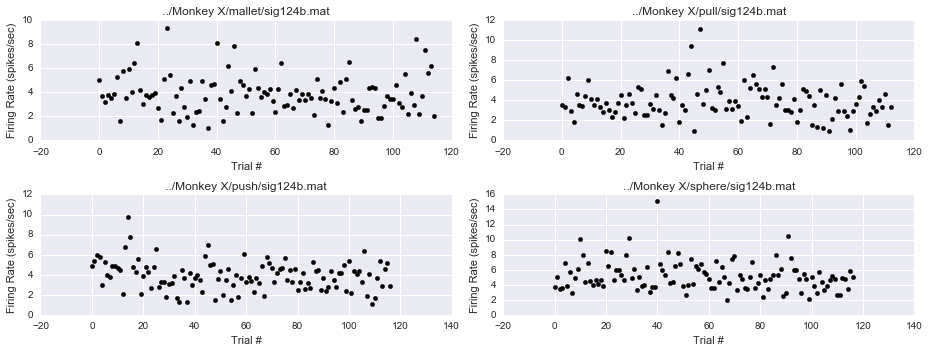

In [42]:
for exp in experiments:
    matFiles = []
    for file in os.listdir(exp):
        if file.endswith('.mat'):
            matFiles.append(file)
    break

    
# loop through each neuron
for file in matFiles: 
    exp = malletDir 
    data = loadmat(exp+file)
    spiketrains = data['trains']
    kinematics = data['kipos']

    avgRates = []
    for trial in spiketrains:
        avgRates.append(_todict(trial)['avgrate'])

    fig = plt.figure(figsize=(13,5))
    plt.subplot(221)
    plt.scatter(np.arange(0,len(avgRates)), avgRates, c='k')
    plt.title(exp + file)
    plt.xlabel('Trial #')
    plt.ylabel('Firing Rate (spikes/sec)')
    
    exp = pullDir
    data = loadmat(exp+file)
    spiketrains = data['trains']
    kinematics = data['kipos']

    avgRates = []
    for trial in spiketrains:
        avgRates.append(_todict(trial)['avgrate'])

    plt.subplot(222)
    plt.scatter(np.arange(0,len(avgRates)), avgRates, c='k')
    plt.title(exp + file)
    plt.xlabel('Trial #')
    plt.ylabel('Firing Rate (spikes/sec)')
    
    exp = pushDir
    data = loadmat(exp+file)
    spiketrains = data['trains']
    kinematics = data['kipos']

    avgRates = []
    for trial in spiketrains:
        avgRates.append(_todict(trial)['avgrate'])

    plt.subplot(223)
    plt.scatter(np.arange(0,len(avgRates)), avgRates, c='k')
    plt.title(exp + file)
    plt.xlabel('Trial #')
    plt.ylabel('Firing Rate (spikes/sec)')
        
    exp = sphereDir
    data = loadmat(exp+file)
    spiketrains = data['trains']
    kinematics = data['kipos']

    avgRates = []
    for trial in spiketrains:
        avgRates.append(_todict(trial)['avgrate'])

    plt.subplot(224)
    plt.scatter(np.arange(0,len(avgRates)), avgRates, c='k')
    plt.title(exp + file)
    plt.xlabel('Trial #')
    plt.ylabel('Firing Rate (spikes/sec)')
    plt.tight_layout()
#         print exp
#         print file
#         print avgRates
#         print len(spiketrains)
        
#         break
#     break